In [2]:
from survival_analysis import prepare_df, obtain_survival_fractions, obtain_total_alive_count
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from scipy.integrate import quad

In [3]:
df = prepare_df()

In [4]:
df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

uen Sector  status           Exit Date          Entry Date Region  \
0   53376145W      N       0 2020-04-30 09:36:00 2018-01-13 10:32:56     NR   
1   53290857X      S       1                 NaT 2015-02-26 12:02:44     CR   
3  200412424K      G       1                 NaT 2004-09-28 17:56:29     WR   
4   53396472E      H       0 2020-10-10 09:36:00 2019-04-11 21:20:43     CR   
5   48376900B      S       0 1999-12-24 04:48:00 1993-04-12 00:00:00    NER   

         age  Dead  
0   4.963723     1  
1   7.843943     0  
3  18.255989     0  
4   3.723477     1  
5  29.722108     1

[0.12218056 0.05819897 8.97407932 9.99474502]


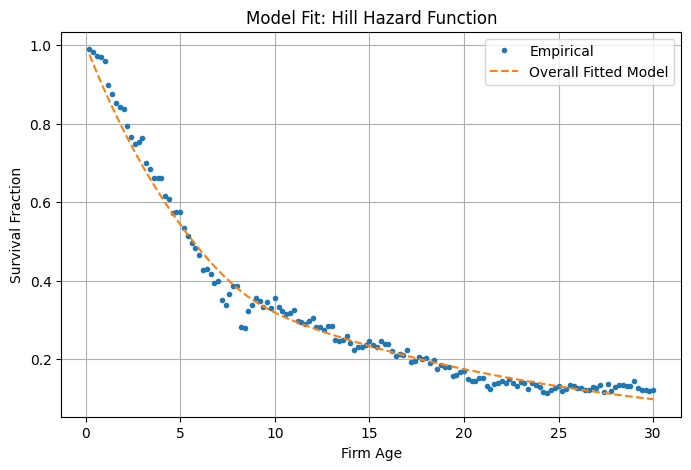

In [5]:
# ---- Step 1: Define the Hill-type hazard function ----

def hill_hazard(a, mu_ub, mu_lb, K, m):
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)  # Add epsilon to avoid div by 0

# ---- Step 2: Define survival function S(a) using quad integration ----

def hill_survival_function(a, mu_ub, mu_lb, K, m):
    result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return np.exp(-result)

# ---- Step 3: Vectorized function to compute model survival over array of ages ----

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m):
    return np.array([hill_survival_function(a, mu_ub, mu_lb, K, m) for a in ages])

# ---- Step 4: Objective function to minimize squared error between model and empirical ----

def objective_hill(params, ages, observed_survival):
    mu_ub, mu_lb, K, m = params
    if mu_ub < mu_lb or mu_ub < 0 or mu_lb < 0:
        return np.inf
    predicted = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    return np.sum((predicted - observed_survival)**2)

# ---- Step 5: Fit parameters ----

def fit_survival_model(ages, survival_fractions, initial_guess=[0.1, 0.05, 5, 10]):
    '''
    Returns the params of the Hill function model giving the least squares error

    Inputs:
    ages = firm age bins
    survival_fractions = survival fraction of firms in each age bin
    initial_guess = initial guess for params [mu_ub, mu_lb, K, m]

    ''' 
    bounds = [(0.01, 0.3), (1e-10, 0.3), (0.1, 30), (0.5, 100)]
    result = minimize(objective_hill, initial_guess, args=(ages, survival_fractions), bounds=bounds)
    return result

# ---- Step 6: Example usage with your data ----

# Create age bins (e.g., every 2 years)
bins = np.arange(0, df_analysis['age'].max() + 1, 0.2)
df_analysis['age_bin'] = pd.cut(df_analysis['age'], bins)


# Compute survival fraction per bin
surv_frac = df_analysis.groupby('age_bin', observed=True)['status'].mean().reset_index()
surv_frac = surv_frac.loc[~(surv_frac == 0).any(axis=1)]
survival_fractions = np.array(surv_frac['status'])
ages = surv_frac['age_bin'].apply(lambda x: x.right)

result = fit_survival_model(ages, survival_fractions, [0.2, 0.05, 5, 10])
best_params = result.x
overall_predicted_curve = model_survival_curve_hill(ages, *best_params)
print(best_params)

# ---- Plot ----
plt.figure(figsize=(8, 5))
plt.plot(ages, survival_fractions, 'o', markersize = 3, label="Empirical")
plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
plt.xlabel("Firm Age")
plt.ylabel("Survival Fraction")
plt.title("Model Fit: Hill Hazard Function")
plt.grid(True)
plt.legend()
plt.show()

[ 0.10698768  0.07005167 12.27841214  5.29302687]


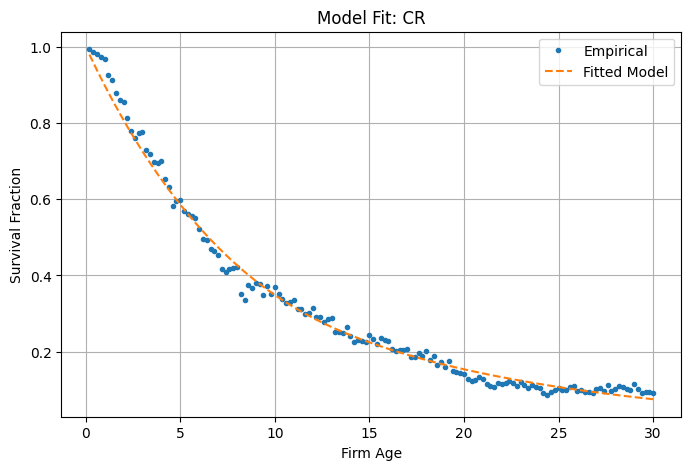

In [5]:
survival_frac, ages = obtain_survival_fractions(df_analysis, 'Region', 'CR')

result = fit_survival_model(ages, survival_frac, [0.2, 0.05, 5, 5])
best_params = result.x
predicted_curve = model_survival_curve_hill(ages, *best_params)
print(best_params)

# Plot model against empirical
plt.figure(figsize=(8, 5))
plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
plt.plot(ages, predicted_curve, '--', label="Fitted Model")
plt.xlabel("Firm Age")
plt.ylabel("Survival Fraction")
plt.title(f"Model Fit: {'CR'}")
plt.grid(True)
plt.legend()
plt.show()

In [6]:
region_list = ['NR','WR','CR','ER','NER']

for region in region_list:
    survival_frac, ages = obtain_survival_fractions(df_analysis, 'Region', region)
    result = fit_survival_model(ages, survival_frac, [0.2, 0.05, 8, 7])
    best_params = result.x
    predicted_curve = model_survival_curve_hill(ages, *best_params)
    print(f'{region}: {best_params}')

    # # Plot model against empirical
    # plt.figure(figsize=(8, 5))
    # plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
    # plt.plot(ages, predicted_curve, '--', label="Fitted Model")
    # plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
    # plt.xlabel("Firm Age")
    # plt.ylabel("Survival Fraction")
    # plt.title(f"Model Fit: {region}")
    # plt.grid(True)
    # plt.legend()
    # plt.show()

NR: [0.13574074 0.01468059 8.98681513 6.98910326]
WR: [1.38430190e-01 2.40740341e-02 8.60832150e+00 1.00000000e+02]
CR: [ 0.10726301  0.07506882 10.92019458  7.17313311]
ER: [0.14417409 0.02666826 9.64267205 7.01975396]
NER: [1.49820212e-01 3.71745012e-02 8.25942813e+00 1.00000000e+02]


F: [7.95451385e-02 1.00000000e-10 2.86208538e+01 1.20016355e+01]


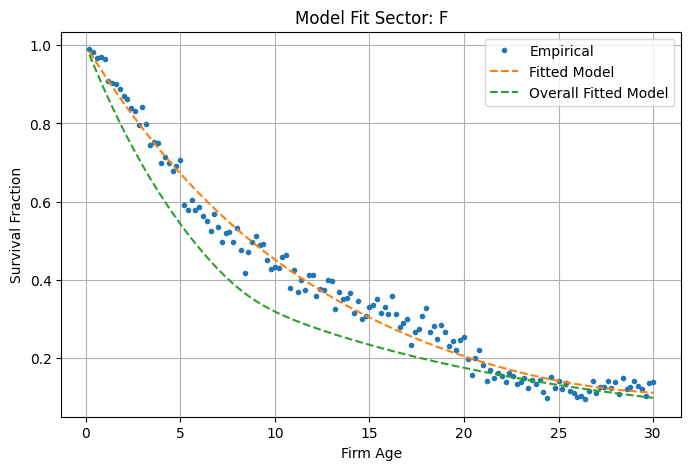

L: [7.57562545e-02 5.85672639e-03 2.61705419e+01 1.00001744e+01]


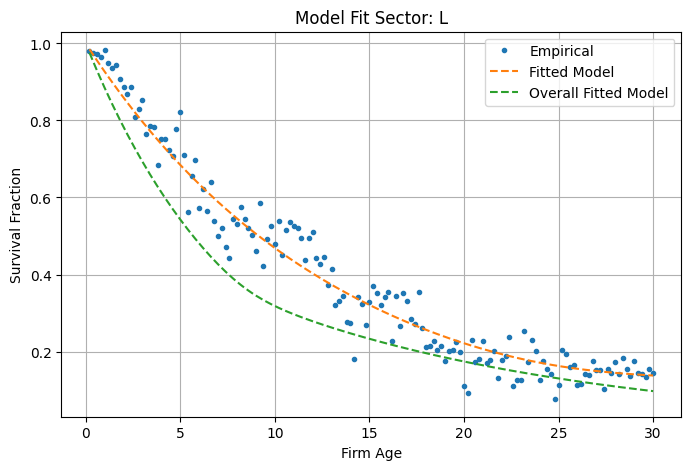

In [7]:
sector_list = ['F', 'L']

for sector in sector_list:
    survival_frac, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    result = fit_survival_model(ages, survival_frac, [0.07998763144579782, 0.01, 26.17074846209418, 10.0])
    best_params = result.x
    predicted_curve = model_survival_curve_hill(ages, *best_params)
    print(f'{sector}: {best_params}')

    # Plot model against empirical
    plt.figure(figsize=(8, 5))
    plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
    plt.plot(ages, predicted_curve, '--', label="Fitted Model")
    plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
    plt.xlabel("Firm Age")
    plt.ylabel("Survival Fraction")
    plt.title(f"Model Fit Sector: {sector}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [8]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']

for sector in sector_list:
    survival_frac, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    result = fit_survival_model(ages, survival_frac, [0.2, 0.03, 9, 5])
    best_params = result.x
    predicted_curve = model_survival_curve_hill(ages, *best_params)
    print(f'{sector}: {best_params}')

    # # Plot model against empirical
    # plt.figure(figsize=(8, 5))
    # plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
    # plt.plot(ages, predicted_curve, '--', label="Fitted Model")
    # plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
    # plt.xlabel("Firm Age")
    # plt.ylabel("Survival Fraction")
    # plt.title(f"Model Fit Sector: {sector}")
    # plt.grid(True)
    # plt.legend()
    # plt.show()

G: [ 0.13557519  0.06119442  9.91855101 28.37901804]
M: [ 0.1097038   0.04915758 11.80623607  5.40536658]


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


F: [0.1427709  0.02096383 8.82787014 4.98418077]
J: [ 0.13237394  0.05570531  9.59637699 10.65350551]
K: [7.23783498e-02 6.42624125e-03 1.74452097e+01 7.90755902e+00]
C: [1.01329542e-01 4.86099066e-02 8.52078240e+00 1.00000000e+02]
H: [1.56593834e-01 4.61012037e-02 6.90836250e+00 1.00000000e+02]
S: [1.40395122e-01 1.00000000e-10 1.29034246e+01 5.10492401e+00]
N: [1.23256986e-01 1.00000000e-10 1.62314002e+01 3.93349967e+00]
I: [1.27228077e-01 1.00000000e-10 2.07384939e+01 3.73566674e+00]
P: [1.21430444e-01 6.70227955e-02 9.47949818e+00 1.00000000e+02]
L: [0.14010446 0.02054281 8.80146452 4.98057058]


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Q: [7.87172720e-02 4.78399527e-02 7.56229192e+00 1.00000000e+02]
R: [1.33210761e-01 8.40125453e-02 8.82538519e+00 1.00000000e+02]


In [24]:
# Negative log-likelihood for binomial MLE
def neg_log_likelihood_hill(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0:
        return np.inf

    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

# Fit function
def fit_hill_model_mle(ages, survivors, totals, initial_guess=[0.3, 0.01, 5.0, 2.0]):
    '''
    ages = vector of ages
    survivors = number of survivors in age bin
    totals = total number of firms in age bin
    initial_guess = [mu_ub, mu_lb, K, m]

    returns best params according to MLE
    
    '''
    bounds = [(0.01, 0.3), (1e-10, 0.3), (0.01, 30), (0.5, 100)]
    result = minimize(neg_log_likelihood_hill, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result.x


In [10]:
region_ll_hill = []
for fil in region_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals)
    
    print(f'{fil} {[float(x) for x in [mu_ub, mu_lb, K, m]]}')    

    # # Plot fit
    # fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

    # print(f'll for {fil}: {-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals)}')
    region_ll_hill.append(neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals))

    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
    # plt.title(f'MLE Hill fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()


NR [0.136997519985397, 0.02355779154418483, 8.313803127053902, 100.0]
WR [0.13907876081827764, 0.02564048511268826, 8.486260225229435, 100.0]
CR [0.10404007532758659, 0.050558263421044906, 17.32386546517892, 5.549887979024525]
ER [0.14743284942552679, 0.03815357128949517, 8.49964983319687, 100.0]
NER [0.1515383757283376, 0.03569624892822053, 8.275610738471816, 100.0]


ll for F: -47800.28245812628
params mu_ub, mu_lb, K, m are [0.08, 0.001, 27.0, 8.0]


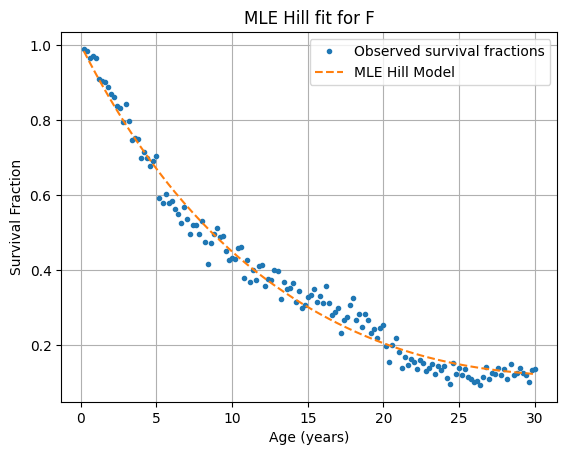

ll for K: -56212.87737841369
params mu_ub, mu_lb, K, m are [0.07012013444682985, 0.011071032156307387, 17.600632045539754, 11.7197538927883]


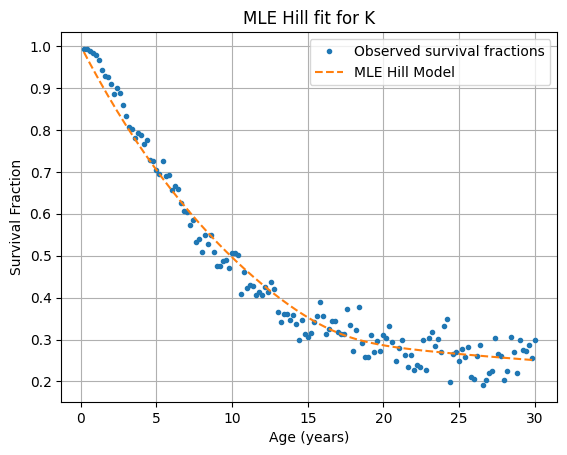

ll for H: -50669.904189963505
params mu_ub, mu_lb, K, m are [0.08, 0.001, 27.0, 8.0]


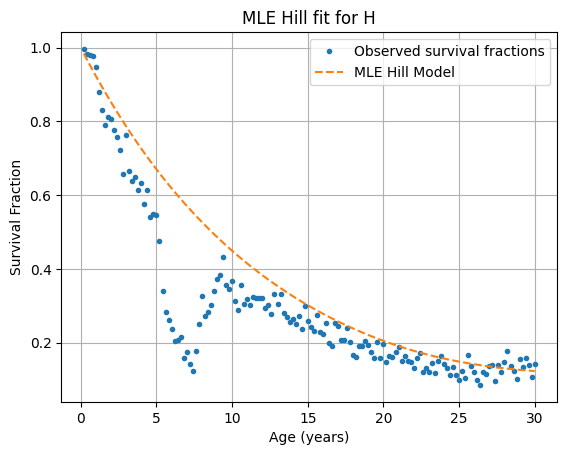

ll for L: -11922.18775744128
params mu_ub, mu_lb, K, m are [0.0742352881373648, 1e-10, 28.271301336276377, 8.561583065547653]


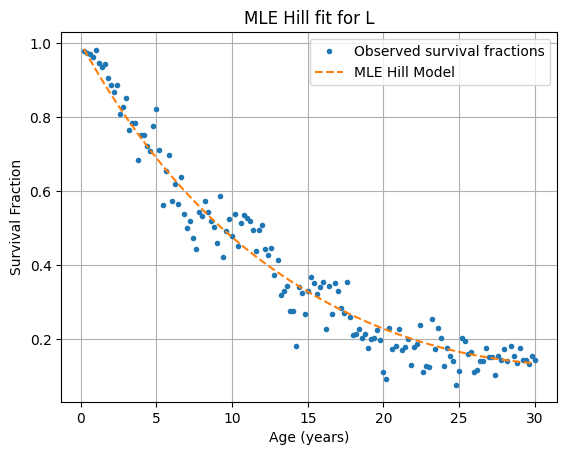

In [11]:
sector_list = ['F', 'K', 'H', 'L']
for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals, [0.08, 0.001, 27, 8])
    print(f'll for {fil}: {-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals)}')

    # Plot fit
    fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

    print(f'params mu_ub, mu_lb, K, m are {[float(x) for x in [mu_ub, mu_lb, K, m]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
    plt.title(f'MLE Hill fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

    #-48281.75199323837

G: [ 0.13660027  0.03574423 12.39113424  4.14356328]
ll for G: -198383.82688326662


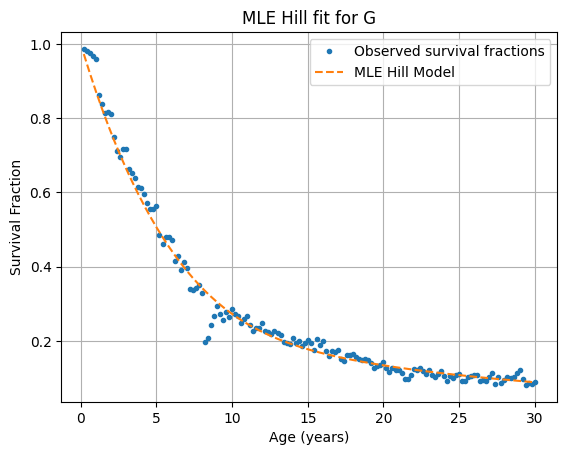

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


M: [ 0.10877533  0.0418096  12.55269306  4.41391222]
ll for M: -106918.42641481012


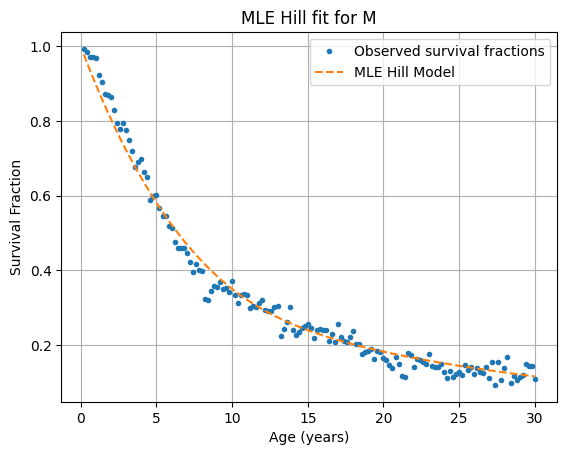

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


F: [ 0.13397865  0.07941962  2.91343986 42.96844049]
ll for F: -48530.51677959216


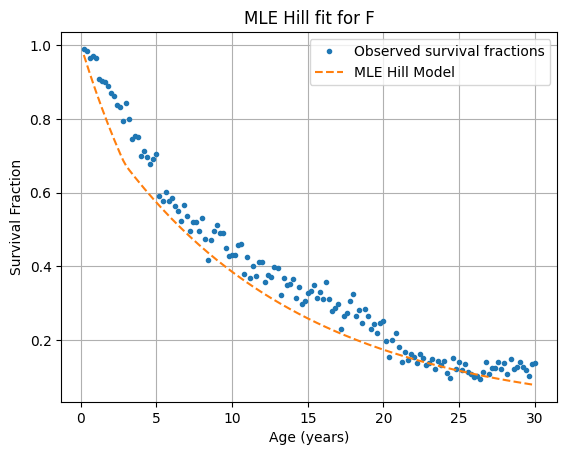

J: [ 0.13090805  0.03791174 11.9429807   4.05657508]
ll for J: -56995.14443231936


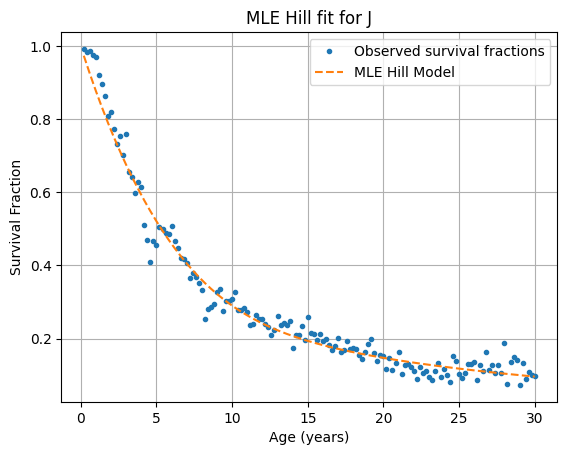

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


K: [7.24648933e-02 6.51735708e-02 1.33585285e+00 7.39690835e+01]
ll for K: -56550.17956636482


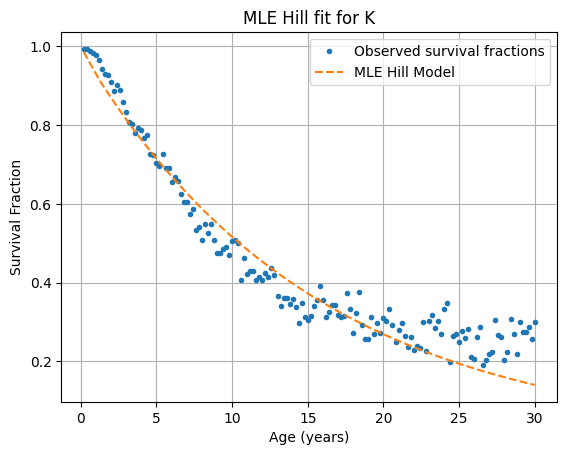

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


C: [0.10301031 0.04128293 9.26045477 8.13925264]
ll for C: -39556.72504649116


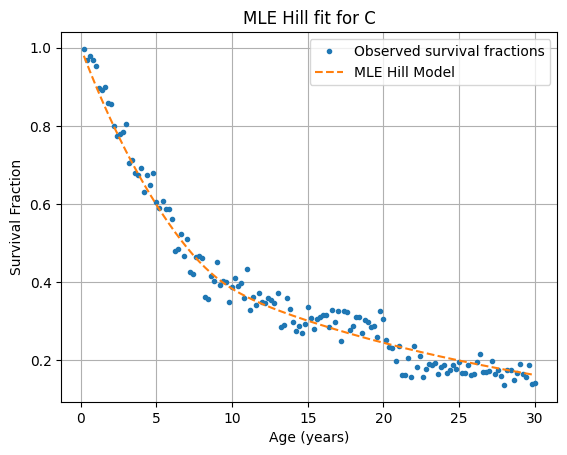

H: [1.90143914e-01 2.80160194e-02 6.93767599e+00 1.00000000e+02]
ll for H: -42974.85049611616


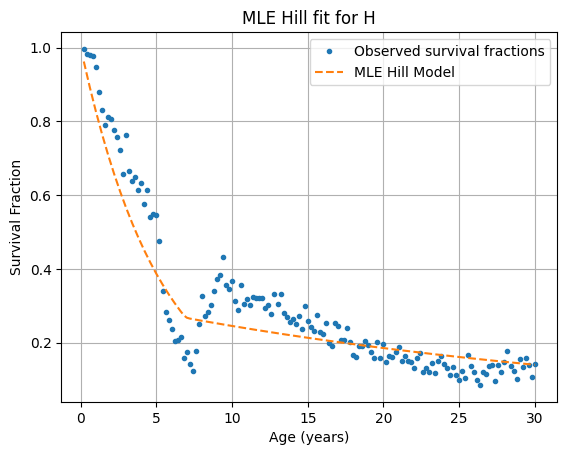

S: [1.40580290e-01 1.00000000e-10 1.29535533e+01 5.18987390e+00]
ll for S: -35752.2869350303


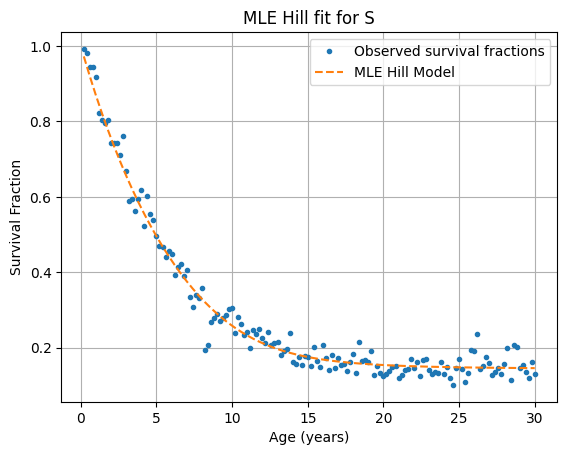

N: [1.23962230e-01 1.00000000e-10 1.64327672e+01 3.67640026e+00]
ll for N: -37012.32213218748


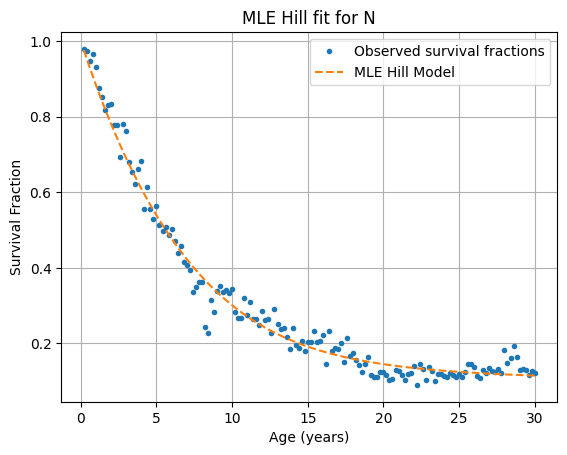

I: [ 0.12568692  0.03447114 17.44283135  5.60609428]
ll for I: -34250.503724023234


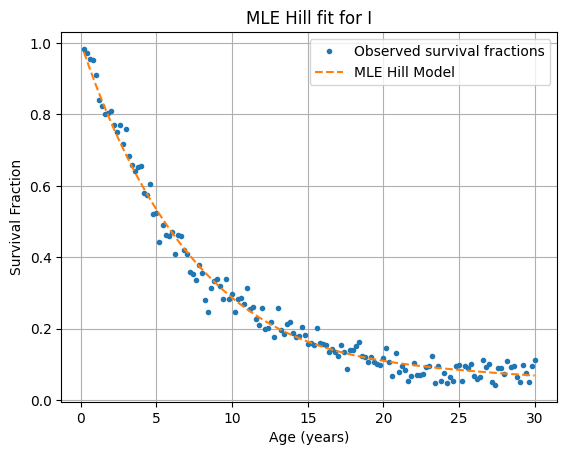

P: [1.21213526e-01 6.86842454e-02 9.44518567e+00 1.00000000e+02]
ll for P: -25155.90457508335


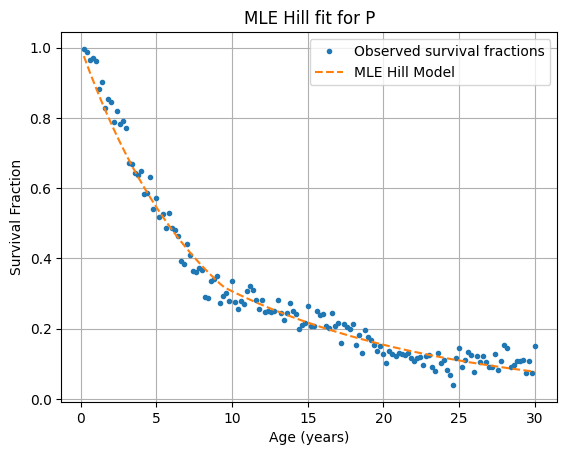

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


L: [ 0.09995713  0.06567195  2.81573161 44.85824257]
ll for L: -11970.807315497192


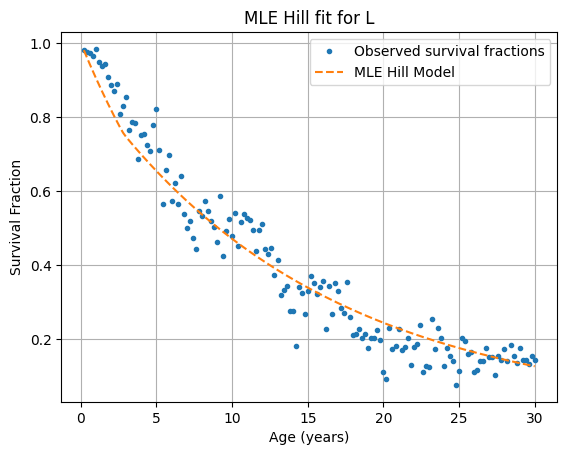

Q: [7.83015990e-02 4.71979345e-02 7.79197632e+00 1.00000000e+02]
ll for Q: -12888.580840466993


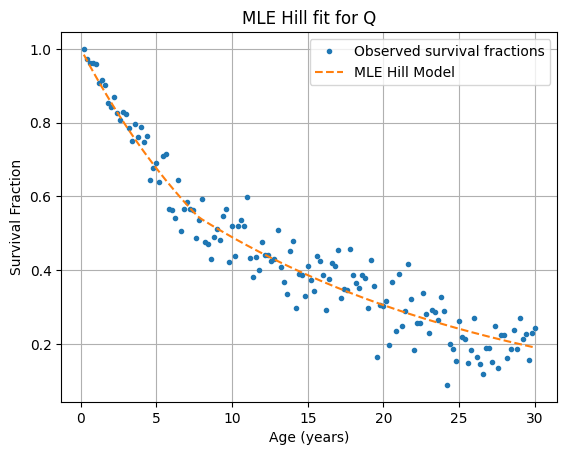

R: [1.32289514e-01 8.54857751e-02 8.85732298e+00 1.00000000e+02]
ll for R: -7519.645951813891


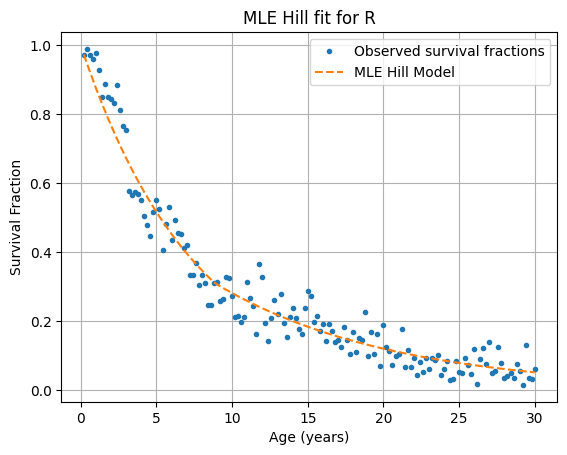

In [12]:
sector_ll_hill = []
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals)

    print(f'{fil}: {fit_hill_model_mle(ages, survivors, totals)}')

    # Plot fit
    fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

    print(f'll for {fil}: {-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals)}')
    sector_ll_hill.append(neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals))

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
    plt.title(f'MLE Hill fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

$f(a) = (1+\alpha t) ^{-\lambda / \alpha}$

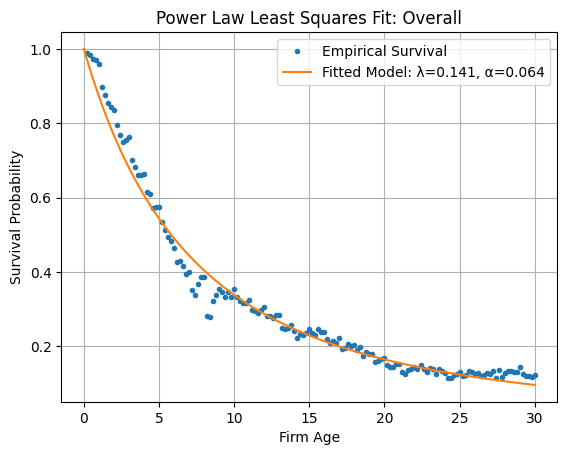

In [13]:
# ---- Closed-form survival function ----
def power_survival_function(t, lam, alpha):
    return (1 + alpha * t) ** (-lam / alpha)

# ---- Predict survival over a list of ages ----
def model_survival_curve_power(ages, lam, alpha):
    return np.array([power_survival_function(t, lam, alpha) for t in ages])

# ---- Least squares objective function ----
def objective_power(params, ages, observed_survival):
    lam, alpha = params
    if lam <= 0 or alpha < 0:
        return np.inf  # invalid parameters
    predicted = model_survival_curve_power(ages, lam, alpha)
    return np.sum((predicted - observed_survival) ** 2)

# ---- Fit the model using least squares ----
def fit_power_model(ages, survival_fractions):
    initial_guess = [0.2, 0.1]  # lambda, alpha
    bounds = [(1e-5, None), (0, None)]
    result = minimize(objective_power, initial_guess, args=(ages, survival_fractions), bounds=bounds)
    return result

# - ages: list or array of firm ages
# - survival_fractions: corresponding empirical survival fractions

# Create age bins (e.g., every 2 years)
bins = np.arange(0, df_analysis['age'].max() + 1, 0.2)
df_analysis['age_bin'] = pd.cut(df_analysis['age'], bins)
# Compute survival fraction per bin
survival_fractions, ages = obtain_survival_fractions(df_analysis)

result = fit_power_model(ages, survival_fractions)
lam_fit, alpha_fit = result.x

# Plot result
ages_sorted = np.linspace(0, max(ages), 100)
fitted_survival = model_survival_curve_power(ages_sorted, lam_fit, alpha_fit)

plt.plot(ages, survival_fractions, 'o', markersize=3, label='Empirical Survival')
plt.plot(ages_sorted, fitted_survival, label='Fitted Model: λ=%.3f, α=%.3f' % (lam_fit, alpha_fit))
plt.xlabel("Firm Age")
plt.ylabel("Survival Probability")
plt.title("Power Law Least Squares Fit: Overall")
plt.grid(True)
plt.legend()
plt.show()


In [14]:
def neg_log_likelihood_power(params, ages, survivors, totals):
    lam, alpha = params
    if lam <= 0 or alpha <= 0:
        return np.inf

    S = power_survival_function(ages, lam, alpha)
    S = np.clip(S, 1e-12, 1 - 1e-12)  # avoid log(0)
    deaths = totals - survivors

    logL = np.sum(survivors * np.log(S) + deaths * np.log(1 - S))
    return -logL

def fit_power_model_mle(ages, survivors, totals):
    initial_guess = [0.1, 0.1]  # lam, alpha
    bounds = [(1e-6, 1), (1e-6, 1)]
    result = minimize(neg_log_likelihood_power, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result.x

ll for NR: -59567.6477521164
params lam, alpha are [0.1886195039277679, 0.18894739950045433]


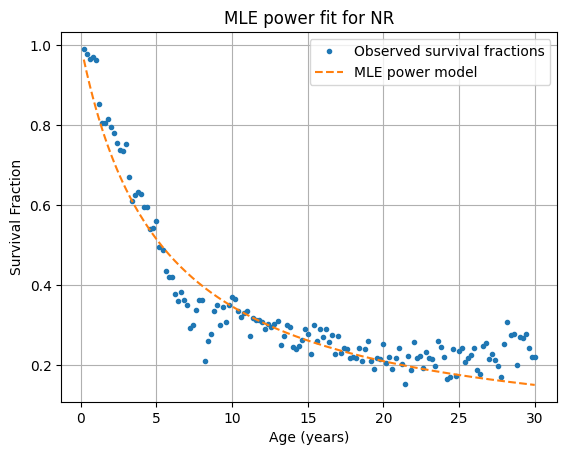

ll for WR: -96324.21879628443
params lam, alpha are [0.1889317727879867, 0.1784994064944407]


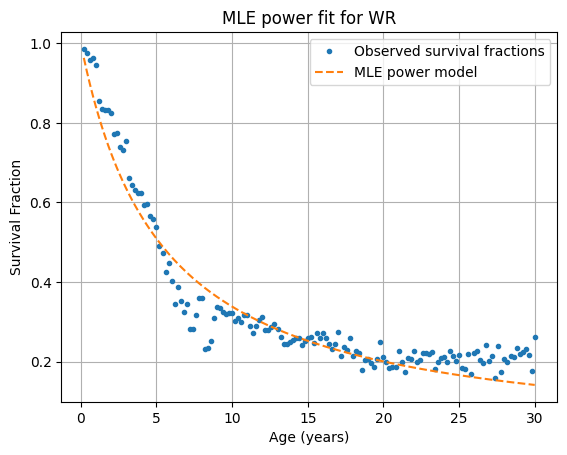

ll for CR: -420253.2008882553
params lam, alpha are [0.11069175500249837, 0.018335267155011367]


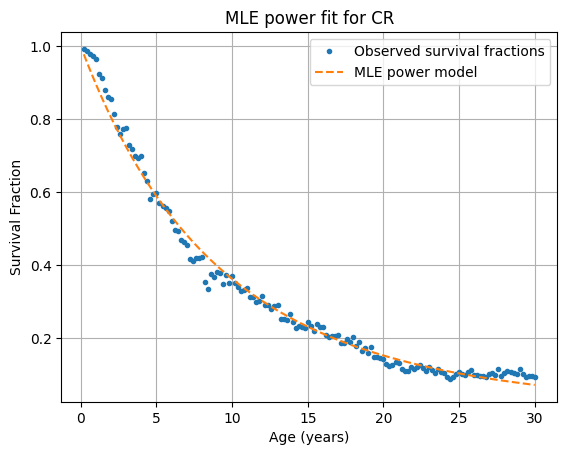

ll for ER: -71816.8062091888
params lam, alpha are [0.19149996695221363, 0.14322742737330993]


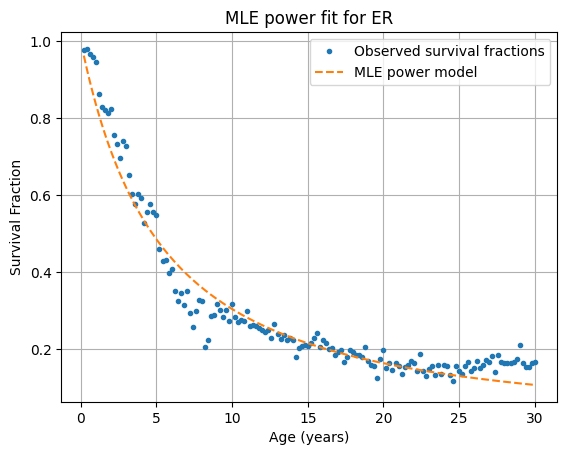

ll for NER: -82060.31237407553
params lam, alpha are [0.1989416274219653, 0.15602637405446237]


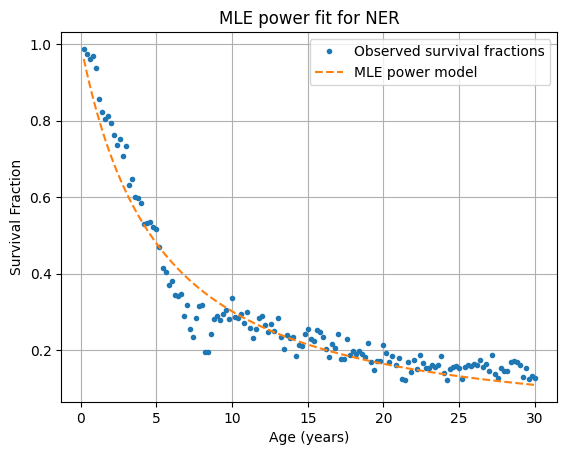

In [15]:
region_ll_power = []
for fil in region_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)

    lam, alpha = fit_power_model_mle(ages, survivors, totals)

    # Plot fit
    fitted_S = model_survival_curve_power(ages, lam, alpha)

    print(f'll for {fil}: {-neg_log_likelihood_power([lam, alpha], ages, survivors, totals)}')
    region_ll_power.append(neg_log_likelihood_power([lam, alpha], ages, survivors, totals))

    print(f'params lam, alpha are {[float(x) for x in [lam, alpha]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE power model', linestyle='--')
    plt.title(f'MLE power fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

ll for G: -198944.67602002577
params lam, alpha are [0.15939620292528545, 0.06554740821430066]


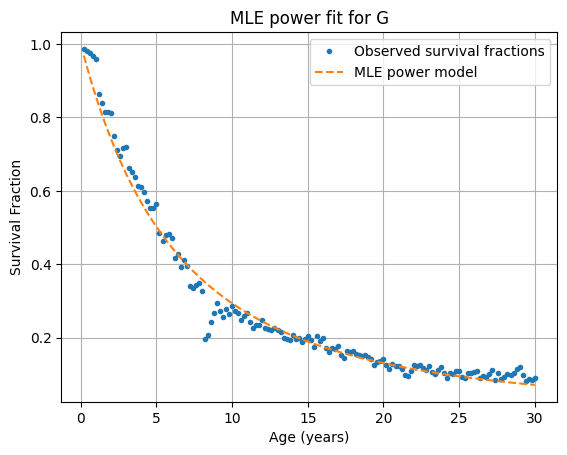

ll for M: -107109.28350819302
params lam, alpha are [0.11731541174879027, 0.034411617250405084]


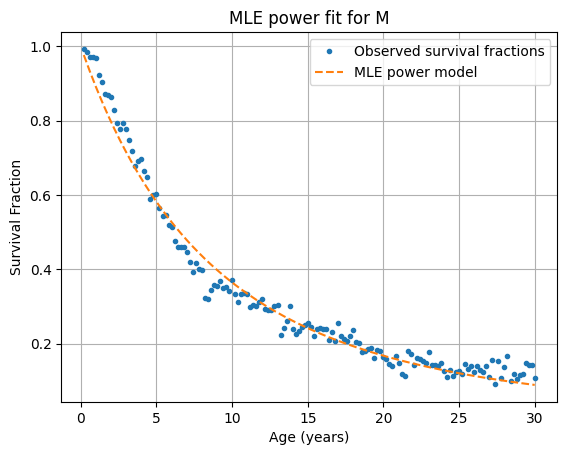

ll for F: -47789.79890249316
params lam, alpha are [0.08176472979107174, 0.003935373274942269]


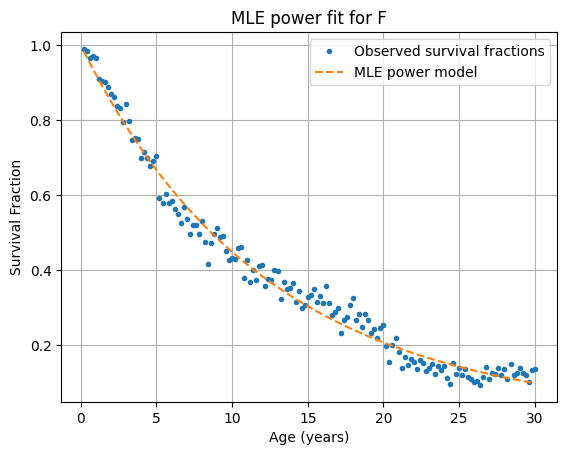

ll for J: -57151.028483457565
params lam, alpha are [0.14493123831512508, 0.05110384606085803]


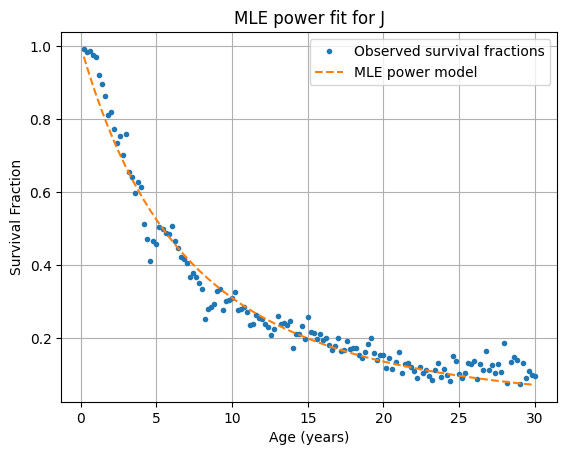

ll for K: -56413.996435860274
params lam, alpha are [0.07428516022902562, 0.0205752635062873]


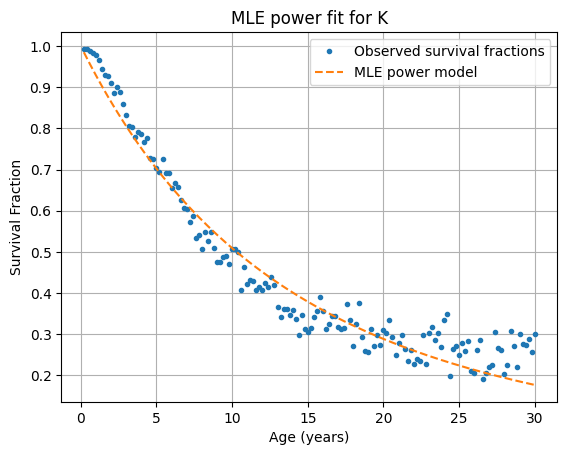

ll for C: -39594.27698304424
params lam, alpha are [0.11483004186551288, 0.06612012042977906]


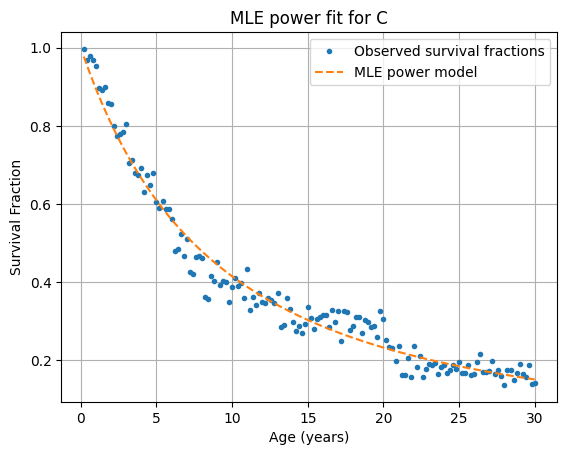

ll for H: -44001.194033551394
params lam, alpha are [0.28873886586023506, 0.2927118075549174]


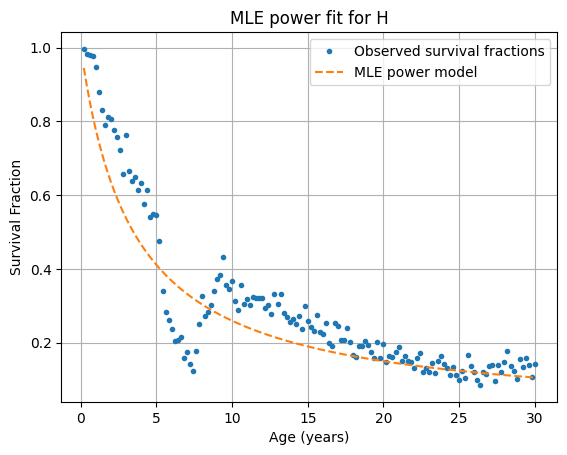

ll for S: -35960.844477007515
params lam, alpha are [0.18288352366120436, 0.11066508198985309]


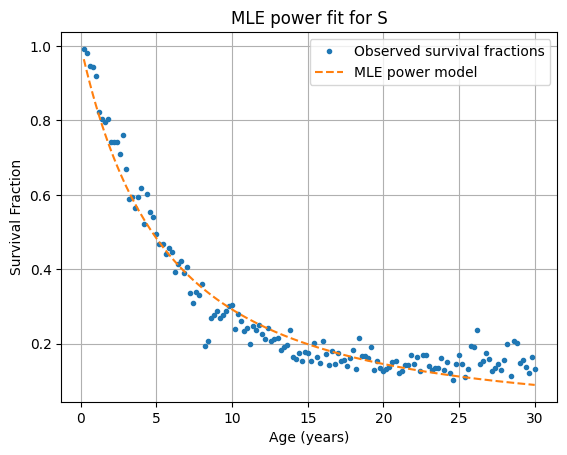

ll for N: -37101.62760374365
params lam, alpha are [0.14828698846245603, 0.06301547388836645]


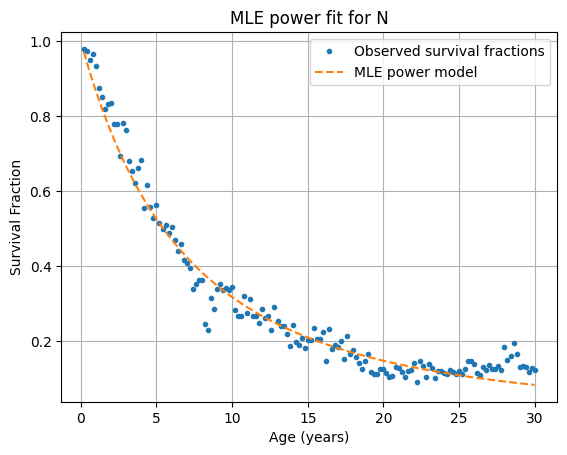

ll for I: -34289.22862246029
params lam, alpha are [0.13748459474217217, 0.026743625773472543]


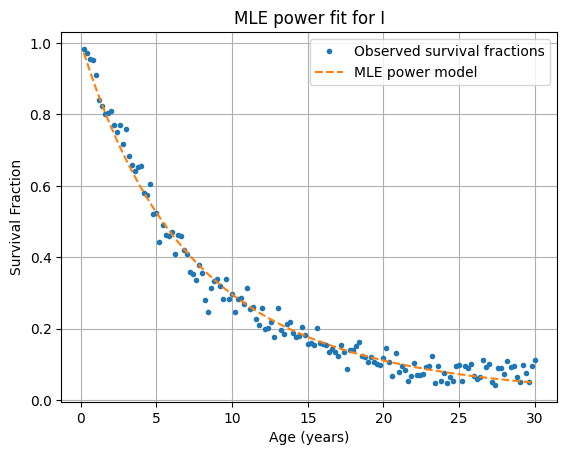

ll for P: -25212.251223789608
params lam, alpha are [0.13180537858715755, 0.03862507110559265]


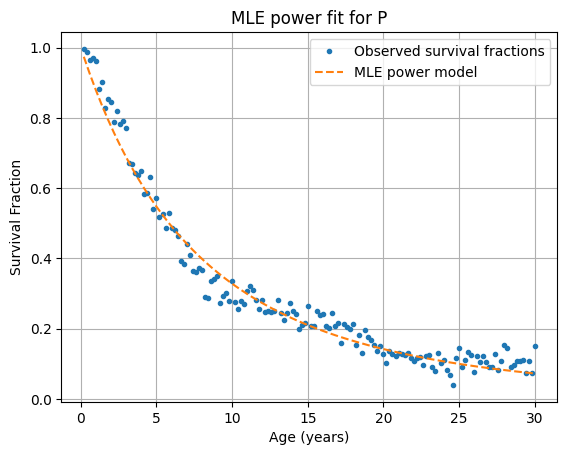

ll for L: -11928.88941323373
params lam, alpha are [0.07361777044103174, 0.0013500005115235382]


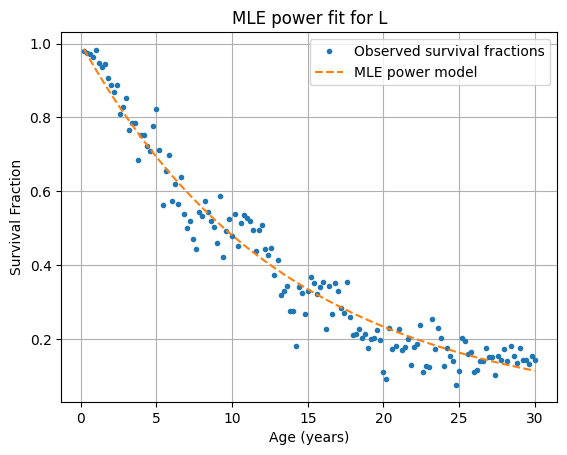

ll for Q: -12903.931859854327
params lam, alpha are [0.08504126422326021, 0.04439811725027947]


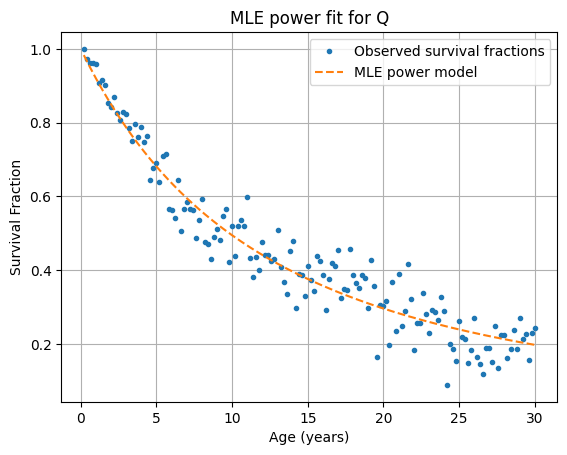

ll for R: -7533.920462008324
params lam, alpha are [0.13942475384045394, 0.02944071706324738]


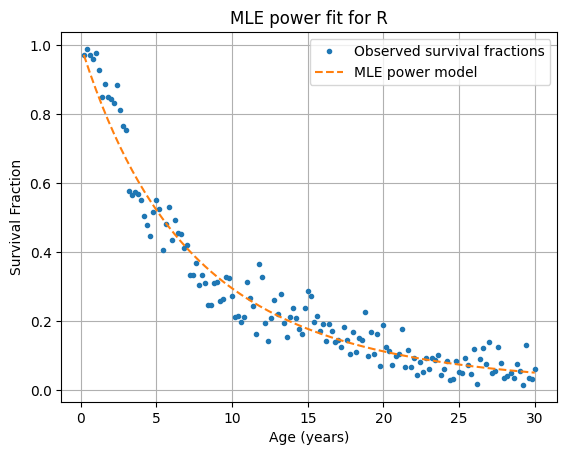

In [16]:
sector_ll_power = []

for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    lam, alpha = fit_power_model_mle(ages, survivors, totals)

    # Plot fit
    fitted_S = model_survival_curve_power(ages, lam, alpha)

    print(f'll for {fil}: {-neg_log_likelihood_power([lam, alpha], ages, survivors, totals)}')
    sector_ll_power.append(neg_log_likelihood_power([lam, alpha], ages, survivors, totals))

    print(f'params lam, alpha are {[float(x) for x in [lam, alpha]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE power model', linestyle='--')
    plt.title(f'MLE power fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
def compute_aic_bic(neg_logL, k, n):
    '''
    k = number of params
    n = number of observations
    '''

    aic = 2 * k + 2 * neg_logL
    bic = k * np.log(n) + 2 * neg_logL
    return aic, bic

In [18]:
region_aic_hill, region_bic_hill = compute_aic_bic(np.array(region_ll_hill), 4, len(ages))
region_aic_power, region_bic_power = compute_aic_bic(np.array(region_ll_power), 2, len(ages))

In [19]:
sector_aic_hill, sector_bic_hill = compute_aic_bic(np.array(sector_ll_hill), 4, len(ages))
sector_aic_power, sector_bic_power = compute_aic_bic(np.array(sector_ll_power), 2, len(ages))

In [20]:
def constant_survival_function(ages, mu):
    return np.exp(-mu * ages)

def model_survival_curve_constant(ages, mu):
    return np.array([constant_survival_function(_, mu) for _ in ages])

def neg_log_likelihood_constant(mu, ages, survivors, totals):
    if mu < 0:
        return np.inf
    S_vals = model_survival_curve_constant(ages, mu)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12) 
    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL

def fit_constant_model_mle(ages, survivors, totals, initial_guess=[0.01]):
    bounds = [(1e-6, None)]
    result = minimize(neg_log_likelihood_constant, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result


In [21]:
# Hill function with number of params k=3, where hill coefficient is set constant at m=5

def hill3k_hazard(a, mu_ub, mu_lb, K):
    return mu_ub - (mu_ub - mu_lb) * (a**5) / (a**5 + K**5 + 1e-10)  # Add epsilon to avoid div by 0

# ---- Step 2: Define survival function S(a) using quad integration ----

def hill3k_survival_function(a, mu_ub, mu_lb, K):
    result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)
    return np.exp(-result)

# ---- Step 3: Vectorized function to compute model survival over array of ages ----

def model_survival_curve_hill3k(ages, mu_ub, mu_lb, K):
    return np.array([hill3k_survival_function(a, mu_ub, mu_lb, K) for a in ages])

# Negative log-likelihood for binomial MLE
def neg_log_likelihood_hill3k(params, ages, survivors, totals):
    mu_ub, mu_lb, K = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0:
        return np.inf

    S_vals = model_survival_curve_hill3k(ages, mu_ub, mu_lb, K)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

# Fit function
def fit_hill3k_model_mle(ages, survivors, totals, initial_guess=[0.1, 0.02, 8.0]):
    '''
    ages = vector of ages
    survivors = number of survivors in age bin
    totals = total number of firms in age bin
    initial_guess = [mu_ub, mu_lb, K]

    returns best params according to MLE
    
    '''
    bounds = [(0.01, 0.3), (1e-10, 0.2), (0.01, 30)]
    result = minimize(neg_log_likelihood_hill3k, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result

In [22]:
region_ll_hill3k = []

for fil in region_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)
    result = fit_hill3k_model_mle(ages, survivors, totals)
    print(f'{fil}: {[float(x) for x in result.x]}')
    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, model_survival_curve_hill3k(ages, *result.x), label='MLE Hill3k Model', linestyle='--')
    # plt.title(f'MLE Hill3k fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    region_ll_hill3k.append(result.fun)

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
sector_ll_hill3k = []
for fil in sector_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)
    result = fit_hill3k_model_mle(ages, survivors, totals, [7.23785797e-02, 6.43020350e-03, 1.74446268e+01])
    print(f'{fil}: {[float(x) for x in result.x]}')
    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, model_survival_curve_hill3k(ages, *result.x), label='MLE Hill3k Model', linestyle='--')
    # plt.title(f'MLE Hill3k fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    sector_ll_hill3k.append(result.fun)

region_aic_hill3k, region_bic_hill3k = compute_aic_bic(np.array(region_ll_hill3k), 3, len(ages))
sector_aic_hill3k, sector_bic_hill3k = compute_aic_bic(np.array(sector_ll_hill3k), 3, len(ages))

NR: [0.13768682098344479, 0.010770197908695578, 9.069066154559453]
WR: [0.13866612413271137, 0.011459381980246465, 9.452105904399511]
CR: [0.10317782572240292, 1e-10, 23.443870677221483]
ER: [0.14602530390843363, 0.021004753468604562, 9.859660970121507]
NER: [0.15292064848485076, 0.025761231388819465, 8.751232941613194]
G: [0.1369457823412897, 0.04482746273060022, 11.400350334361963]
M: [0.10815483721445963, 0.046534053101995126, 12.551575296193832]
F: [0.07990758927247996, 0.07259777450708982, 19.761022783579403]
J: [0.13114576156109975, 0.04852501347621307, 10.762058114871234]


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


K: [0.0723785797, 0.0064302035, 17.4446268]
C: [0.10061435059712309, 0.045621982115199085, 9.019555921816513]
H: [0.1965292000339535, 0.023075820167158295, 6.8144347615635334]
S: [0.14089904603201123, 1e-10, 12.922719709488728]
N: [0.12139723965336907, 1e-10, 16.58567315374942]
I: [0.1252053683520725, 1e-10, 20.412090901501028]
P: [0.12129643770216465, 0.05989529969852383, 10.670291049379776]
L: [0.07442589142109755, 0.019988859206756356, 30.0]
Q: [0.07931950337645591, 0.04609385537294938, 7.6403927937991165]
R: [0.13249393751659774, 0.08111059212329473, 9.513405896505404]


In [23]:
region_ll_constant = []
for fil in region_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)
    result = fit_constant_model_mle(ages, survivors, totals)
    print(result.x[0])
    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, model_survival_curve_constant(ages, result.x[0]), label='MLE Constant Model', linestyle='--')
    # plt.title(f'MLE Constant fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    region_ll_constant.append(result.fun)

sector_ll_constant = []
for fil in sector_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)
    result = fit_constant_model_mle(ages, survivors, totals)
    sector_ll_constant.append(result.fun)

region_aic_constant, region_bic_constant = compute_aic_bic(np.array(region_ll_constant), 1, len(ages))
sector_aic_constant, sector_bic_constant = compute_aic_bic(np.array(sector_ll_constant), 1, len(ages))

0.061223827267648474
0.06628598434456348
0.0675765970290663
0.07453318976241881
0.07266647382982325


In [24]:
region_df_aic = pd.DataFrame({
    'Region': region_list,
    'AIC_Hill': region_aic_hill,
    'AIC_Power': region_aic_power,
    'AIC_Hill3k': region_aic_hill3k,
    'AIC_Constant': region_aic_constant
})
region_df_aic.head()

Region       AIC_Hill      AIC_Power     AIC_Hill3k  AIC_Constant
0     NR  118068.077116  119139.295504  118195.503403  2.582175e+07
1     WR  190914.527568  192652.437593  191089.909997  4.232045e+07
2     CR  839888.595550  840510.401777  839837.644211  2.080739e+08
3     ER  142705.091828  143637.612418  142760.381960  3.303534e+07
4    NER  162703.662051  164124.624748  162964.703743  3.751901e+07

In [25]:
region_df_bic = pd.DataFrame({
    'Region': region_list,
    'BIC_Hill': region_bic_hill,
    'BIC_Power': region_bic_power,
    'BIC_Hill3k': region_bic_hill3k,
    'BIC_Constant': region_bic_constant
})
region_df_bic.head()

Region       BIC_Hill      BIC_Power     BIC_Hill3k  BIC_Constant
0     NR  118080.119657  119145.316775  118204.535309  2.582176e+07
1     WR  190926.570109  192658.458863  191098.941903  4.232046e+07
2     CR  839900.638091  840516.423047  839846.676117  2.080739e+08
3     ER  142717.134369  143643.633689  142769.413866  3.303534e+07
4    NER  162715.704592  164130.646019  162973.735649  3.751902e+07

In [26]:
sector_df_aic = pd.DataFrame({
    'Sector': sector_list,
    'AIC_Constant': sector_aic_constant,
    'AIC_Power': sector_aic_power,
    'AIC_Hill3k': sector_aic_hill3k,
    'AIC_Hill': sector_aic_hill,
})
sector_df_aic.head(14)

Sector  AIC_Constant      AIC_Power     AIC_Hill3k       AIC_Hill
0       G  9.854523e+07  397893.352040  396727.016189  396775.653767
1       M  4.977623e+07  214222.567016  213821.041420  213844.852830
2       F  2.278440e+07   95583.597805   95590.605563   97069.033559
3       J  2.775384e+07  114306.056967  113985.691443  113998.288865
4       K  2.481625e+07  112831.992872  112481.129233  113108.359133
5       C  1.788151e+07   79192.553966   79105.046179   79121.450093
6       H  1.962410e+07   88006.388067   86635.328649   85957.700992
7       S  1.710177e+07   71925.688954   71510.756063   71512.573870
8       N  1.756619e+07   74207.255207   74040.192226   74032.644264
9       I  1.725667e+07   68582.457245   68503.782821   68509.007448
10      P  1.181524e+07   50428.502448   50344.656675   50319.809150
11      L  5.589731e+06   23861.778826   23856.179439   23949.614631
12      Q  5.423488e+06   25811.863720   25792.824239   25785.161681
13      R  3.934248e+06   15071.840924   15053.045860   15047.291904

Constant model AIC: 24276350
Other models AIC range: 101961 - 102280
Exclude constant model: True


C:\Users\chong\AppData\Local\Temp\ipykernel_6616\2443602549.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  axes[0].plot(comparison_df['Parameters'], comparison_df['Mean_AIC'], 'ro-',


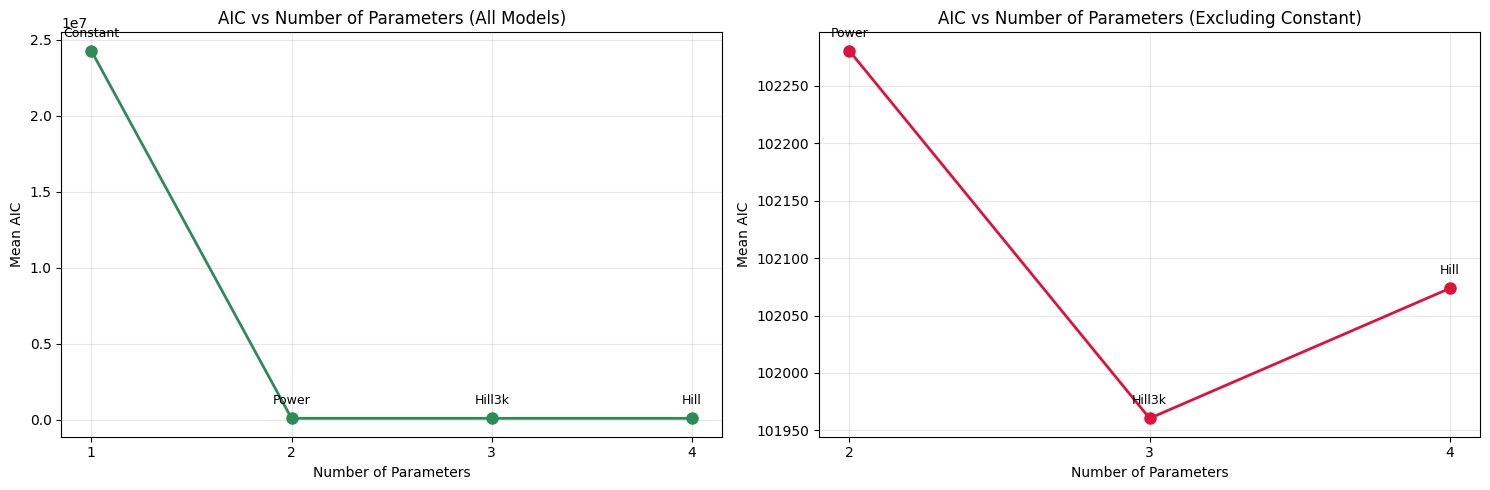

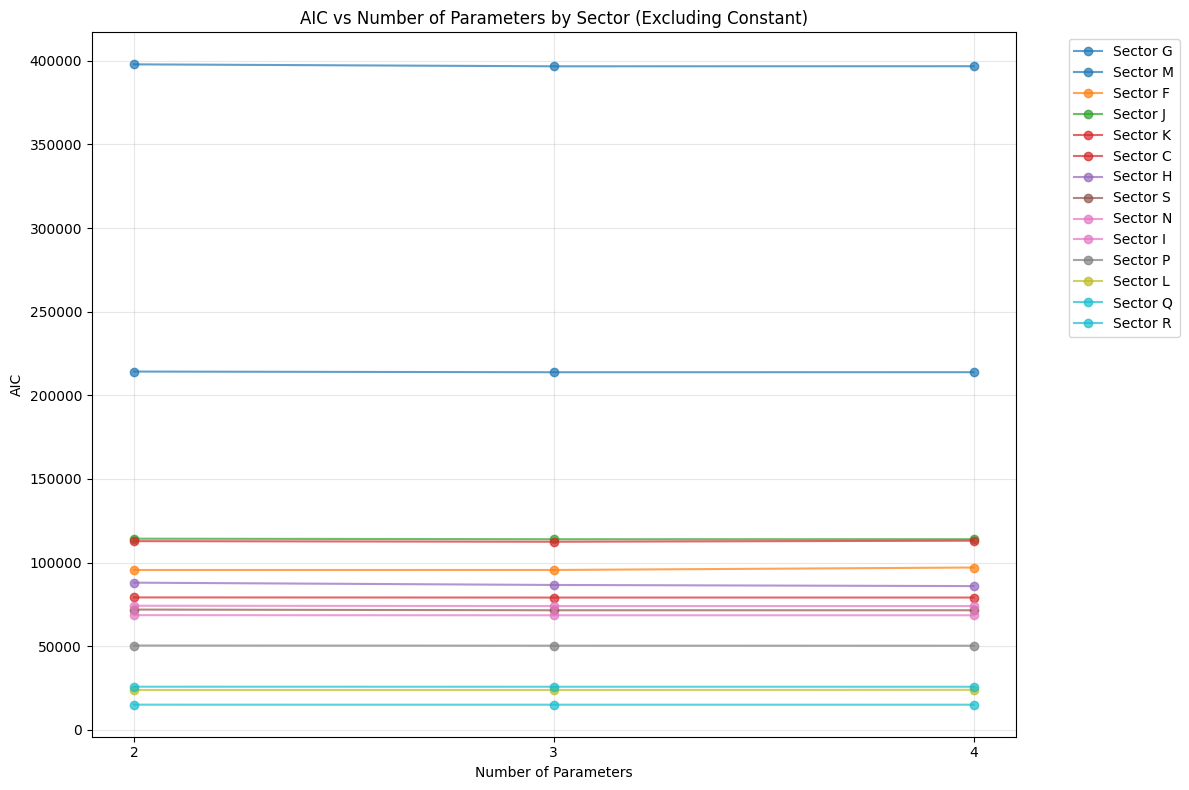

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the number of parameters for each model
model_params = {
    'AIC_Hill': 4,
    'AIC_Power': 2, 
    'AIC_Hill3k': 3,
    'AIC_Constant': 1
}

# Calculate mean AIC values across all sectors for each model
mean_aic = {}
for col in ['AIC_Hill', 'AIC_Power', 'AIC_Hill3k', 'AIC_Constant']:
    mean_aic[col] = sector_df_aic[col].mean()

# Create comparison dataframe
comparison_data = []
for model, aic_val in mean_aic.items():
    comparison_data.append({
        'Model': model,
        'Parameters': model_params[model],
        'Mean_AIC': aic_val
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Parameters')

# Check if Constant model AIC is very different (outlier)
other_models = comparison_df[comparison_df['Model'] != 'AIC_Constant']['Mean_AIC']
constant_aic = comparison_df[comparison_df['Model'] == 'AIC_Constant']['Mean_AIC'].iloc[0]
aic_range = other_models.max() - other_models.min()
constant_diff = abs(constant_aic - other_models.mean())

# Determine if constant should be excluded (if it's more than 2x the range of other models)
exclude_constant = constant_diff > (2 * aic_range)

print(f"Constant model AIC: {constant_aic:.0f}")
print(f"Other models AIC range: {other_models.min():.0f} - {other_models.max():.0f}")
print(f"Exclude constant model: {exclude_constant}")

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: All models including Constant
axes[0].plot(comparison_df['Parameters'], comparison_df['Mean_AIC'], 'ro-', 
            linewidth=2, markersize=8, color='#2E8B57')
axes[0].set_xlabel('Number of Parameters')
axes[0].set_ylabel('Mean AIC')
axes[0].set_title('AIC vs Number of Parameters (All Models)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks([1, 2, 3, 4])

# Add model labels
for _, row in comparison_df.iterrows():
    model_name = row['Model'].replace('AIC_', '')
    axes[0].annotate(model_name, 
                    (row['Parameters'], row['Mean_AIC']),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center', fontsize=9)

# Plot 2: Exclude Constant if it's an outlier, otherwise show all
if exclude_constant:
    filtered_df = comparison_df[comparison_df['Model'] != 'AIC_Constant']
    title = 'AIC vs Number of Parameters (Excluding Constant)'
    color = '#DC143C'
else:
    filtered_df = comparison_df
    title = 'AIC vs Number of Parameters (All Models)'
    color = '#2E8B57'

axes[1].plot(filtered_df['Parameters'], filtered_df['Mean_AIC'], 'o-', 
            linewidth=2, markersize=8, color=color)
axes[1].set_xlabel('Number of Parameters')
axes[1].set_ylabel('Mean AIC')
axes[1].set_title(title)
axes[1].grid(True, alpha=0.3)

if exclude_constant:
    axes[1].set_xticks([2, 3, 4])
else:
    axes[1].set_xticks([1, 2, 3, 4])

# Add model labels for second plot
for _, row in filtered_df.iterrows():
    model_name = row['Model'].replace('AIC_', '')
    axes[1].annotate(model_name, 
                    (row['Parameters'], row['Mean_AIC']),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Alternative: Create individual sector plots to see variation
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each sector as a separate line
colors = plt.cm.tab10(np.linspace(0, 1, len(sector_df_aic)))

for i, (_, sector_row) in enumerate(sector_df_aic.iterrows()):
    sector_name = sector_row['Sector']
    
    # Get AIC values for this sector
    sector_aic = [
        sector_row['AIC_Constant'],  # 1 parameter
        sector_row['AIC_Power'],     # 2 parameters
        sector_row['AIC_Hill3k'],    # 3 parameters
        sector_row['AIC_Hill']       # 4 parameters
    ]
    
    parameters = [1, 2, 3, 4]
    
    # Exclude constant if needed
    if exclude_constant:
        sector_aic = sector_aic[1:]  # Remove first element (Constant)
        parameters = parameters[1:]  # Remove first element (1 parameter)
    
    ax.plot(parameters, sector_aic, 'o-', 
           label=f'Sector {sector_name}', 
           color=colors[i], alpha=0.7, linewidth=1.5)

ax.set_xlabel('Number of Parameters')
ax.set_ylabel('AIC')
if exclude_constant:
    ax.set_title('AIC vs Number of Parameters by Sector (Excluding Constant)')
    ax.set_xticks([2, 3, 4])
else:
    ax.set_title('AIC vs Number of Parameters by Sector')
    ax.set_xticks([1, 2, 3, 4])

ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [28]:
import plotly.express as px
import plotly.graph_objects as go

def create_plotly_for_your_data(df, hide_constant=True):
    """Create simple Plotly plot of AIC vs Model Type"""
    
    # Get AIC columns
    aic_columns = [col for col in df.columns if col.startswith('AIC_')]
    
    # Option to hide AIC_Constant
    if hide_constant and 'AIC_Constant' in aic_columns:
        aic_columns.remove('AIC_Constant')
    
    # Melt the dataframe
    df_melted = df.melt(id_vars=['Sector'], 
                        value_vars=aic_columns,
                        var_name='Model', 
                        value_name='AIC')
    
    # Clean up model names
    df_melted['Model_Name'] = df_melted['Model'].str.replace('AIC_', '')
    
    # Create the plot
    fig = px.line(df_melted, 
                  x='Model_Name', 
                  y='AIC',
                  color='Sector',
                  markers=True,
                  title='AIC Values by Model Type')
    
    # Add mean line
    mean_data = df_melted.groupby('Model_Name')['AIC'].mean().reset_index()
    
    fig.add_trace(go.Scatter(
        x=mean_data['Model_Name'],
        y=mean_data['AIC'],
        mode='lines+markers',
        name='Mean',
        line=dict(color='black', width=3, dash='dash'),
        marker=dict(size=8)
    ))
    
    # Simple layout
    fig.update_layout(
        xaxis_title="Model Type",
        yaxis_title="AIC (lower is better)",
        hovermode='x unified',
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1.02
        ),
        width=1000,
        height=600
    )
    
    return fig

In [29]:
fig = create_plotly_for_your_data(sector_df_aic)
fig.show()

In [30]:
sector_df_bic = pd.DataFrame({
    'Sector': sector_list,
    'BIC_Hill': sector_bic_hill,
    'BIC_Power': sector_bic_power,
    'BIC_Hill3k': sector_bic_hill3k,
    'BIC_Constant': sector_bic_constant
})
sector_df_bic.head(14)

Sector       BIC_Hill      BIC_Power     BIC_Hill3k  BIC_Constant
0       G  396787.696308  397899.373311  396736.048095  9.854523e+07
1       M  213856.895371  214228.588287  213830.073326  4.977624e+07
2       F   97081.076100   95589.619076   95599.637469  2.278440e+07
3       J  114010.331406  114312.078238  113994.723348  2.775384e+07
4       K  113120.401674  112838.014142  112490.161139  2.481625e+07
5       C   79133.492634   79198.575237   79114.078085  1.788151e+07
6       H   85969.743533   88012.409338   86644.360555  1.962411e+07
7       S   71524.616411   71931.710225   71519.787969  1.710178e+07
8       N   74044.686806   74213.276478   74049.224132  1.756620e+07
9       I   68521.049989   68588.478516   68512.814727  1.725667e+07
10      P   50331.851691   50434.523718   50353.688581  1.181525e+07
11      L   23961.657172   23867.800097   23865.211345  5.589734e+06
12      Q   25797.204222   25817.884990   25801.856145  5.423491e+06
13      R   15059.334445   15077.862195   15062.077766  3.934251e+06

In [31]:
df_long = region_df_aic.melt(id_vars="Region", 
                  var_name="Model", 
                  value_name="AIC_Value")


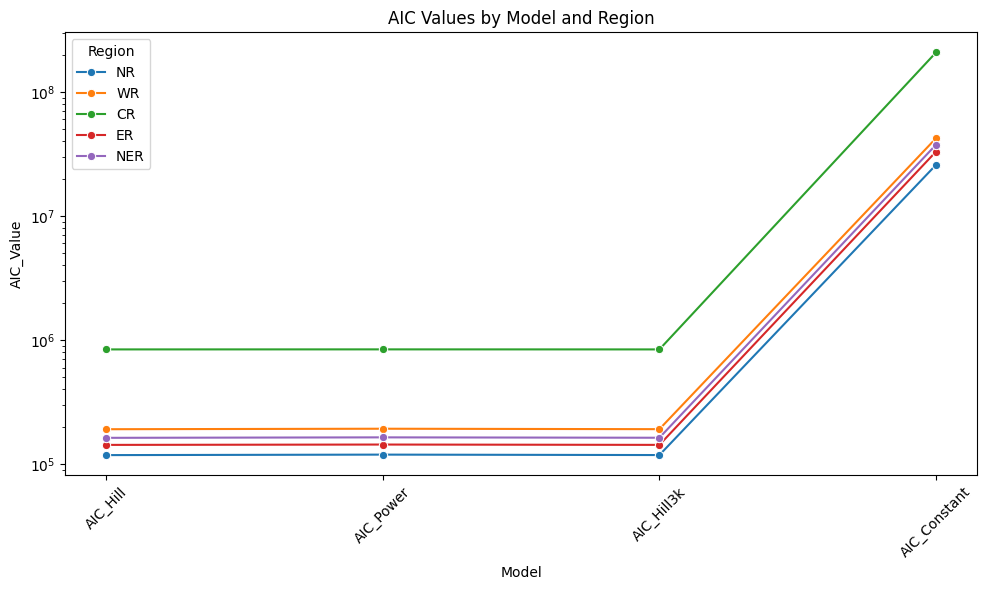

In [32]:
# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x="Model", y="AIC_Value", hue="Region", marker="o")
plt.xticks(rotation=45)
plt.title("AIC Values by Model and Region")
plt.yscale("log")
plt.tight_layout()
plt.show()

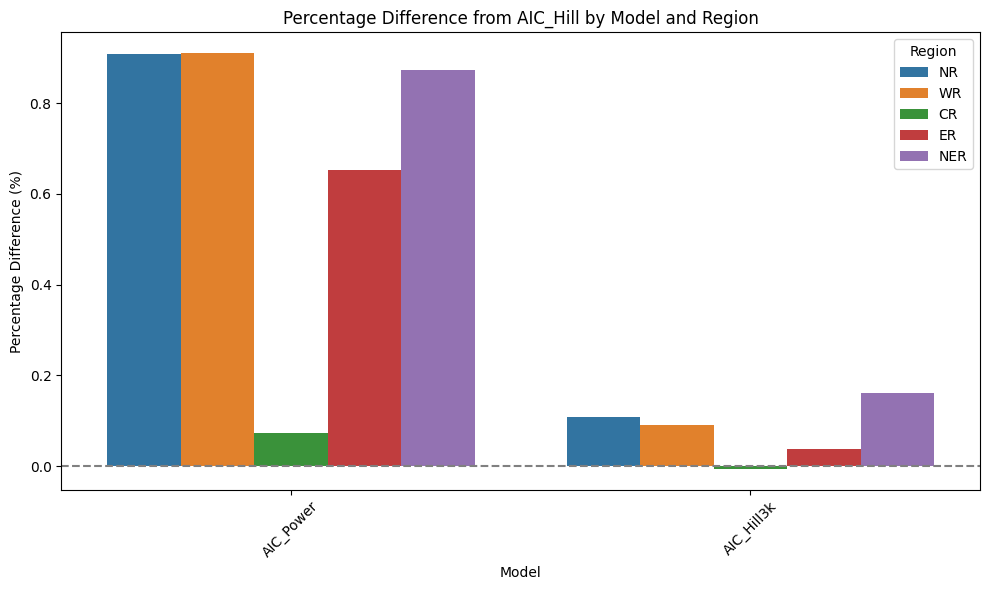

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Original AIC values
dftest = region_df_aic.copy()

# Step 1: Calculate % difference from AIC_Hill
base_model = "AIC_Hill"
compare_models = ["AIC_Power", "AIC_Hill3k"]
dftest_diff = dftest[["Region", base_model] + compare_models].copy()

# Compute percentage differences
for model in compare_models:
    dftest_diff[model] = 100 * (dftest_diff[model] - dftest_diff[base_model]) / dftest_diff[base_model]

# Step 2: Reshape for plotting
dftest_melted = dftest_diff.melt(id_vars="Region", 
                         value_vars=compare_models, 
                         var_name="Model", 
                         value_name="Percent_Diff")

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=dftest_melted, x="Model", y="Percent_Diff", hue="Region")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Percentage Difference from AIC_Hill by Model and Region")
plt.ylabel("Percentage Difference (%)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

params mu_ub, mu_lb, K, m for NR are [0.136997519985397, 0.02355779154418483, 8.313803127053902, 100.0]
params mu_ub, mu_lb, K, m for WR are [0.13907876081827764, 0.02564048511268826, 8.486260225229435, 100.0]
params mu_ub, mu_lb, K, m for CR are [0.10404007532758659, 0.050558263421044906, 17.32386546517892, 5.549887979024525]
params mu_ub, mu_lb, K, m for ER are [0.14743284942552679, 0.03815357128949517, 8.49964983319687, 100.0]
params mu_ub, mu_lb, K, m for NER are [0.1515383757283376, 0.03569624892822053, 8.275610738471816, 100.0]


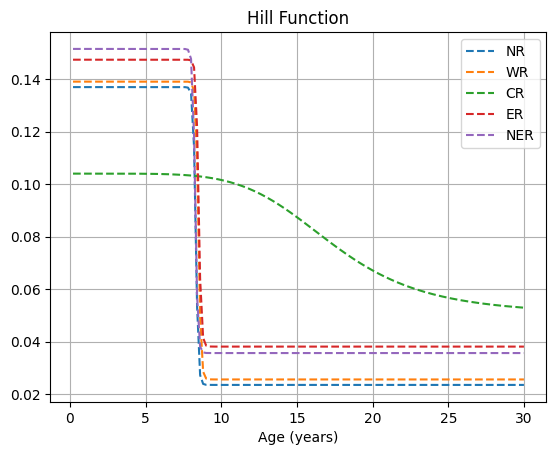

In [34]:
for fil in region_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals)

    print(f'params mu_ub, mu_lb, K, m for {fil} are {[float(x) for x in [mu_ub, mu_lb, K, m]]}')

    plt.plot(ages, hill_hazard(ages, mu_ub, mu_lb, K, m), label = fil, linestyle='--')
plt.title(f'Hill Function')
plt.xlabel('Age (years)')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K', 'm'],
                        index=sector_list)

df_params.head(14)

mu_ub         mu_lb          K           m
G  0.136600  3.574423e-02  12.391134    4.143563
M  0.108775  4.180960e-02  12.552693    4.413912
F  0.079990  1.000000e-10  26.182377   79.999864
J  0.130908  3.791174e-02  11.942981    4.056575
K  0.070120  1.107103e-02  17.600632   11.719754
C  0.103010  4.128293e-02   9.260455    8.139253
H  0.190144  2.801602e-02   6.937676  100.000000
S  0.140580  1.000000e-10  12.953553    5.189874
N  0.123962  1.000000e-10  16.432767    3.676400
I  0.125687  3.447114e-02  17.442831    5.606094
P  0.121214  6.868425e-02   9.445186  100.000000
L  0.074121  1.000000e-10  25.775318   79.998605
Q  0.078302  4.719794e-02   7.791976  100.000000
R  0.132290  8.548577e-02   8.857323  100.000000

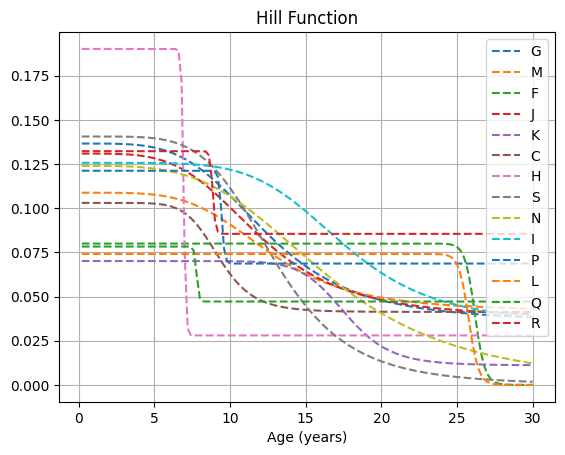

In [36]:
for param in parameters:

    plt.plot(ages, hill_hazard(ages, *param), label = sector_list[parameters.index(param)], linestyle='--')

plt.title(f'Hill Function')
plt.xlabel('Age (years)')
plt.legend()
plt.grid(True)
plt.show()

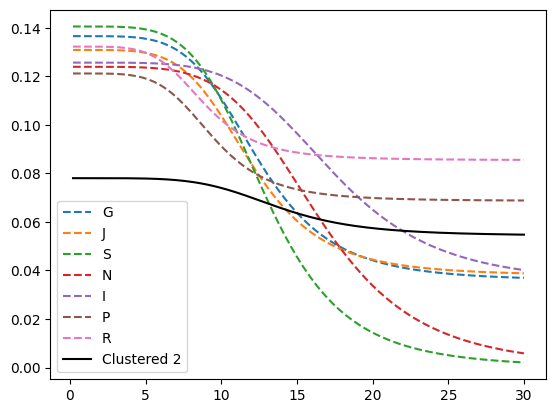

In [37]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424],
    [0.10877533, 0.0418096, 12.55269306],
    [0.079990154, 1.00E-10, 26.18237719],
    [0.13090805, 0.03791174, 11.9429807],
    [0.070120134, 0.011071032, 17.60063205],
    [0.10301031, 0.04128293, 9.26045477],
    [0.190143914, 0.028016019, 6.93767599],
    [0.14058029, 1.00E-10, 12.9535533],
    [0.12396223, 1.00E-10, 16.4327672],
    [0.12568692, 0.03447114, 17.44283135],
    [0.121213526, 0.068684245, 9.44518567],
    [0.074121126, 1.00E-10, 25.77531849],
    [0.078301599, 0.047197935, 7.79197632],
    [0.132289514, 0.085485775, 8.85732298]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K'],
                        index=sector_list)

# Plot only for ['G', 'J', 'S', 'N', 'I', 'P', 'R']
selected_sectors = ['G', 'J', 'S', 'N', 'I', 'P', 'R']

# selected2 = ['F', 'K', 'C', 'L', 'Q']

for param in parameters:
    if sector_list[parameters.index(param)] in selected_sectors:
        plt.plot(ages, hill3k_hazard(ages, *param), label = sector_list[parameters.index(param)], linestyle='--')

# # Cluster params
# #   mu_ub: 0.133491
# #   mu_lb: 0.060737
# #   K: 9.922621
# #   m: 30.806709

# plt.plot(ages, hill_hazard(ages, 0.133491, 0.060737, 9.922621, 30.806709), label = 'Clustered', color='black')
# plt.legend()
# plt.show()

# for param in parameters:
#     if sector_list[parameters.index(param)] in selected2:
#         plt.plot(ages, hill_hazard(ages, *param), label = sector_list[parameters.index(param)], linestyle='--')

# Cluster 2 (5 sectors): ['F', 'K', 'C', 'L', 'Q']
#   mu_ub: 0.074804
#   mu_lb: 0.000000
#   K: 24.163392
#   m: 55.891670

# Cluster 2 (5 sectors): ['F', 'K', 'C', 'L', 'Q']
#   mu_ub: 0.078053
#   mu_lb: 0.054304
#   K: 13.732254
#   m: 5.0 (fixed)

plt.plot(ages, hill3k_hazard(ages, 0.078053, 0.054304, 13.732254), label = 'Clustered 2', color='black')
plt.legend()
plt.show()

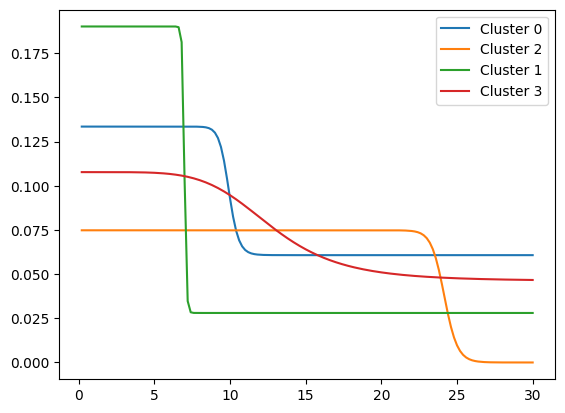

In [38]:
plt.plot(ages, hill_hazard(ages, 0.133491, 0.060737, 9.922621, 30.806709), label = 'Cluster 0')
plt.plot(ages, hill_hazard(ages, 0.074804, 0.000000, 24.163392, 55.891670), label = 'Cluster 2')
# # Cluster 1 (1 sectors): ['H']
#   mu_ub: 0.190143
#   mu_lb: 0.028018
#   K: 6.937616
#   m: 104.814104

# Cluster 3 (1 sectors): ['M']
#   mu_ub: 0.107725
#   mu_lb: 0.046107
#   K: 12.731183
#   m: 5.433634

plt.plot(ages, hill_hazard(ages, 0.190143, 0.028018, 6.987616, 104.814104), label = 'Cluster 1')
plt.plot(ages, hill_hazard(ages, 0.107725, 0.046107, 12.731183, 5.43364), label = 'Cluster 3')

plt.legend()
plt.show()

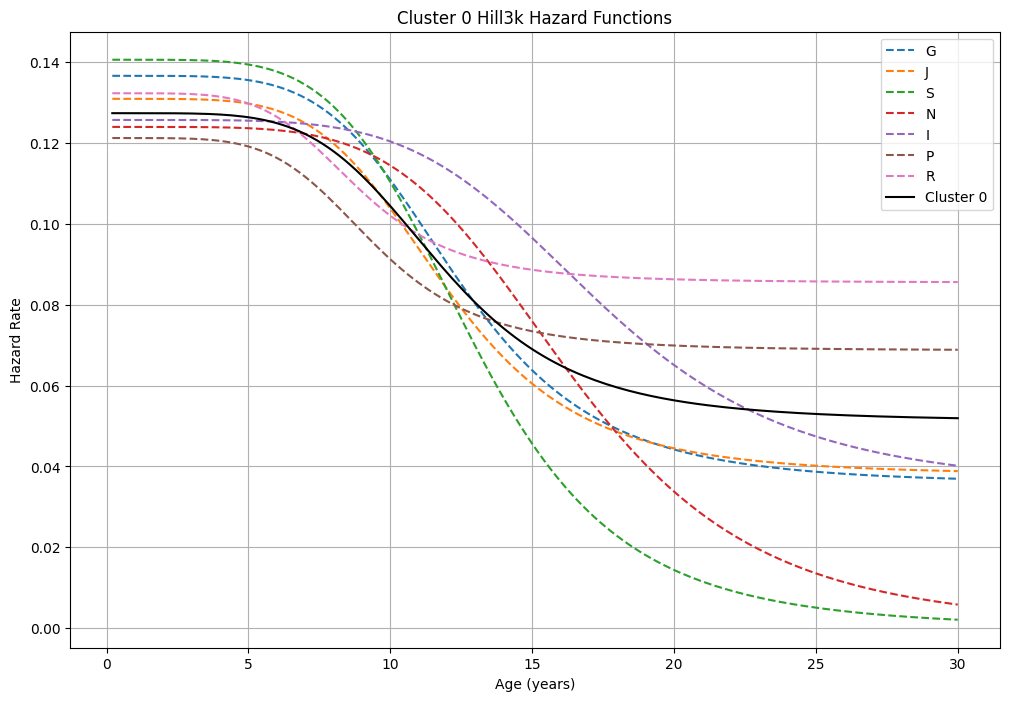

In [39]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424],
    [0.10877533, 0.0418096, 12.55269306],
    [0.079990154, 1.00E-10, 26.18237719],
    [0.13090805, 0.03791174, 11.9429807],
    [0.070120134, 0.011071032, 17.60063205],
    [0.10301031, 0.04128293, 9.26045477],
    [0.190143914, 0.028016019, 6.93767599],
    [0.14058029, 1.00E-10, 12.9535533],
    [0.12396223, 1.00E-10, 16.4327672],
    [0.12568692, 0.03447114, 17.44283135],
    [0.121213526, 0.068684245, 9.44518567],
    [0.074121126, 1.00E-10, 25.77531849],
    [0.078301599, 0.047197935, 7.79197632],
    [0.132289514, 0.085485775, 8.85732298]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K'],
                        index=sector_list)

# Plot only for ['G', 'J', 'S', 'N', 'I', 'P', 'R']
cluster_0 = ['J', 'N', 'I', 'P', 'R']

fig, ax = plt.subplots(figsize=(12, 8))

for param in parameters:
    if sector_list[parameters.index(param)] in selected_sectors:
        plt.plot(ages, hill3k_hazard(ages, *param), label = sector_list[parameters.index(param)], linestyle='--')

# Cluster 0 (5 sectors): ['J', 'N', 'I', 'P', 'R']
#   mu_ub: 0.127360
#   mu_lb: 0.051201
#   K: 11.826997
#   m: 5.0 (fixed)

plt.plot(ages, hill3k_hazard(ages, 0.127360, 0.051201, 11.826997), label = 'Cluster 0', color='black')

# Cluster 1 (1 sectors): ['M']
#   mu_ub: 0.108155
#   mu_lb: 0.046538
#   K: 12.551068
#   m: 5.0 (fixed)

# plt.plot(ages, hill3k_hazard(ages, 0.108155, 0.046538, 12.551068), label = 'Cluster 1', color='blue')

# Cluster 2 (5 sectors): ['F', 'K', 'C', 'L', 'Q']
#   mu_ub: 0.078053
#   mu_lb: 0.054305
#   K: 13.731646
#   m: 5.0 (fixed)

# plt.plot(ages, hill3k_hazard(ages, 0.078053, 0.054305, 13.731646), label = 'Cluster 2', color='green')

# Cluster 3 (3 sectors): ['G', 'H', 'S']
#   mu_ub: 0.148172
#   mu_lb: 0.044724
#   K: 9.492480
#   m: 5.0 (fixed)

# plt.plot(ages, hill3k_hazard(ages, 0.148172, 0.044724, 9.492480), label = 'Cluster 3', color='red')

plt.title('Cluster 0 Hill3k Hazard Functions')
plt.xlabel('Age (years)')
plt.ylabel('Hazard Rate')
plt.legend()
plt.grid(True)
plt.show()

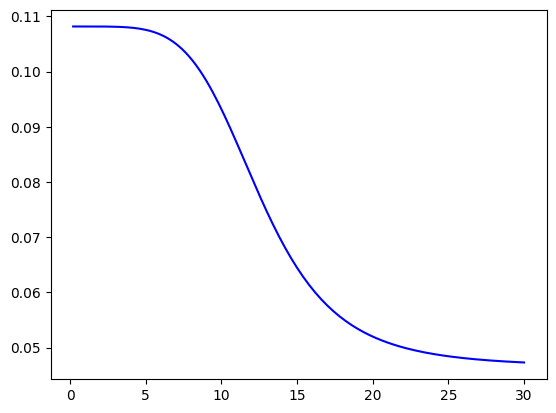

In [40]:
# Cluster 1 (1 sectors): ['M']
#   mu_ub: 0.108155
#   mu_lb: 0.046538
#   K: 12.551068
#   m: 5.0 (fixed)

plt.plot(ages, hill3k_hazard(ages, 0.108155, 0.046538, 12.551068), label = 'Cluster 1', color='blue')

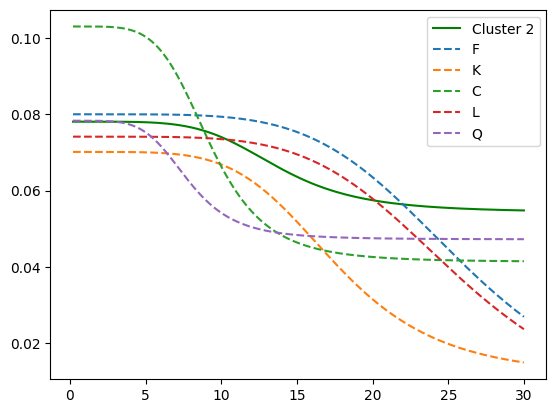

In [41]:
# Cluster 2 (5 sectors): ['F', 'K', 'C', 'L', 'Q']
#   mu_ub: 0.078053
#   mu_lb: 0.054305
#   K: 13.731646
#   m: 5.0 (fixed)

plt.plot(ages, hill3k_hazard(ages, 0.078053, 0.054305, 13.731646), label = 'Cluster 2', color='green')

cluster_2 = ['F', 'K', 'C', 'L', 'Q']
for param in parameters:
    if sector_list[parameters.index(param)] in cluster_2:
        plt.plot(ages, hill3k_hazard(ages, *param), label = sector_list[parameters.index(param)], linestyle='--')

plt.legend()
plt.show()

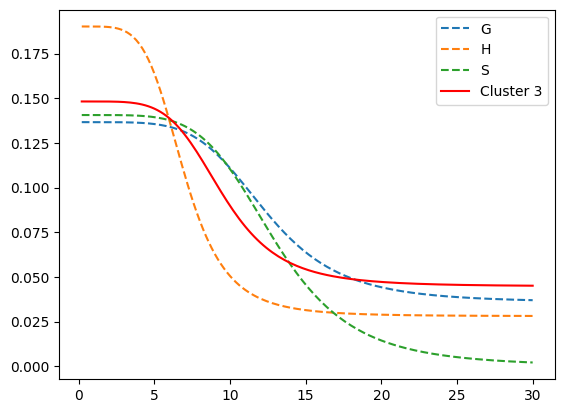

In [42]:
cluster_3 = ['G', 'H', 'S']
for param in parameters:
    if sector_list[parameters.index(param)] in cluster_3:
        plt.plot(ages, hill3k_hazard(ages, *param), label = sector_list[parameters.index(param)], linestyle='--')

plt.plot(ages, hill3k_hazard(ages, 0.148172, 0.044724, 9.492480), label = 'Cluster 3', color='red')

plt.legend()

C:\Users\chong\AppData\Local\Temp\ipykernel_2224\3083880374.py:31: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = quad(lambda s: hazard_with_bump(s, mu_ub, mu_lb, K, m, delta, a1, a2), 0, age)
C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


[ 0.13660027  0.03574423 12.39113424  4.14356328  0.1         5.
  7.        ]


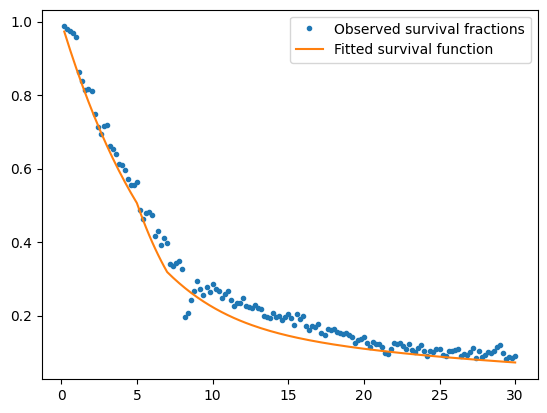

In [13]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K', 'm'],
                        index=sector_list)

def hazard_with_bump(age, mu_ub, mu_lb, K, m, delta, a1, a2):
    base = hill_hazard(age, mu_ub, mu_lb, K, m)
    bump = delta if (a1 <= age <= a2) else 0
    return base + bump

def survival_with_bump(age, mu_ub, mu_lb, K, m, delta, a1, a2):
    # Integrate hazard_with_bump from 0 to age
    result, _ = quad(lambda s: hazard_with_bump(s, mu_ub, mu_lb, K, m, delta, a1, a2), 0, age)
    return np.exp(-result)

def model_survival_with_bump(ages, mu_ub, mu_lb, K, m, delta, a1, a2):
    return np.array([survival_with_bump(a, mu_ub, mu_lb, K, m, delta, a1, a2) for a in ages])

def neg_log_likelihood_bump(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m, delta, a1, a2 = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0 or delta < 0 or a2 <= a1:
        return np.inf
    S_vals = np.array([survival_with_bump(a, mu_ub, mu_lb, K, m, delta, a1, a2) for a in ages])
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)
    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL

sector = 'G'
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
initial_guess = [*df_params.loc[sector], 0.1, 5, 7]  # [mu_ub, mu_lb, K, m, delta, a1, a2]
bounds = [(0.01, 0.3), (1e-10, 0.3), (0.1, 30), (0.5, 100), (0, 5), (0, 10), (5, 30)]
result = minimize(neg_log_likelihood_bump, initial_guess, args=(ages, survivors, totals), bounds=bounds)
print(result.x)

plt.plot(ages, survival_fractions, 'o', markersize=3, label='Observed survival fractions')
plt.plot(ages, model_survival_with_bump(ages, *result.x), label='Fitted survival function')
plt.legend()
plt.show()

[1.58117741e-01 4.07804981e-02 7.38812209e+00 1.00000000e+02
 5.00000000e+00 4.78944439e-01 2.00000000e+00]
-42492.01835878602


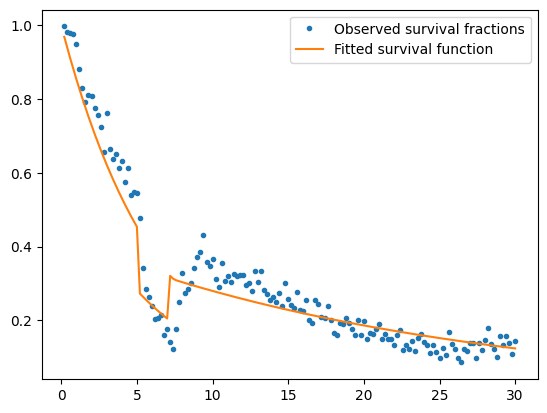

In [21]:
def survival_with_bump(a, mu_ub, mu_lb, K, m, trigger_age, impulse_intensity, delta_width):
    """
    Survival function for Hill model with delta trigger (analytical integration)
    """
    if a <= 0:
        return 1.0
    
    try:
        # Base Hill survival (already has the integrated hazard built in)
        base_survival = hill_survival_function(a, mu_ub, mu_lb, K, m)
        
        # Delta function contribution
        if a > trigger_age and a <= trigger_age + delta_width:
            # If we're within the delta width, apply the impulse
            delta_contribution = impulse_intensity
        else:
            # Outside of range
            delta_contribution = 0.0
        
        # Total survival = base_survival * exp(-delta_contribution)
        total_survival = base_survival * np.exp(-delta_contribution)
        
        return max(1e-12, min(1.0, total_survival))
        
    except Exception as e:
        print(f"Calculation failed for a={a}: {e}")
        return max(1e-12, np.exp(-a * mu_ub))  # Fallback

def model_survival_with_bump(ages, mu_ub, mu_lb, K, m, trigger_age, impulse_intensity, delta_width):
    """
    Vectorized survival curve with delta trigger (analytical approach)
    """
    return np.array([
        survival_with_bump(a, mu_ub, mu_lb, K, m, trigger_age, impulse_intensity, delta_width) 
        for a in ages
    ])

def neg_log_likelihood_bump(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m, trigger_age, impulse_intensity, delta_width = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0 or impulse_intensity < 0 or delta_width <= 0:
        return np.inf
    S_vals = model_survival_with_bump(ages, mu_ub, mu_lb, K, m, trigger_age, impulse_intensity, delta_width)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)
    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL

sector = 'H'
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
initial_guess = [*df_params.loc[sector], 5, 0.5, 2]  # [mu_ub, mu_lb, K, m, trigger_age, impulse_intensity, delta_width]
bounds = [(0.01, 0.3), (1e-10, 0.3), (0.1, 30), (0.5, 100), (0, 15), (0, 2), (0, 10)]
result = minimize(neg_log_likelihood_bump, initial_guess, args=(ages, survivors, totals), bounds=bounds)
print(result.x)
print(-result.fun)

plt.plot(ages, survival_fractions, 'o', markersize=3, label='Observed survival fractions')
plt.plot(ages, model_survival_with_bump(ages, *result.x), label='Fitted survival function')
plt.legend()
plt.show()

Data summary: 150 age points, range 0.2 to 30.0
Survival range: 0.081 to 0.987
Dip appears to be between indices 24 and 49
Corresponding to ages 5.0 to 10.0
Fitting windowed mortality model...
Using differential evolution for global optimization...
differential_evolution step 1: f(x)= 199113.3299473605
differential_evolution step 2: f(x)= 199113.3299473605
differential_evolution step 3: f(x)= 199012.2084512062
differential_evolution step 4: f(x)= 199012.2084512062
differential_evolution step 5: f(x)= 198483.8873946338
differential_evolution step 6: f(x)= 198256.0242072084
differential_evolution step 7: f(x)= 198256.0242072084
differential_evolution step 8: f(x)= 198256.0242072084
differential_evolution step 9: f(x)= 198256.0242072084
Polishing solution with 'L-BFGS-B'
Differential evolution result: [1.25539468e-01 5.73878145e-02 1.19442422e+01 6.68292195e+01
 6.50408433e+00 1.77659265e-01 3.34273678e+00]
Log-likelihood: -198006.28

Refining with L-BFGS-B...


C:\Users\chong\AppData\Local\Temp\ipykernel_2224\3107269172.py:162: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_local = minimize(


Local optimization result: [1.25540127e-01 5.73875977e-02 1.19442420e+01 6.68292194e+01
 6.50408433e+00 1.77659705e-01 3.34273678e+00]
Final log-likelihood: -198006.28


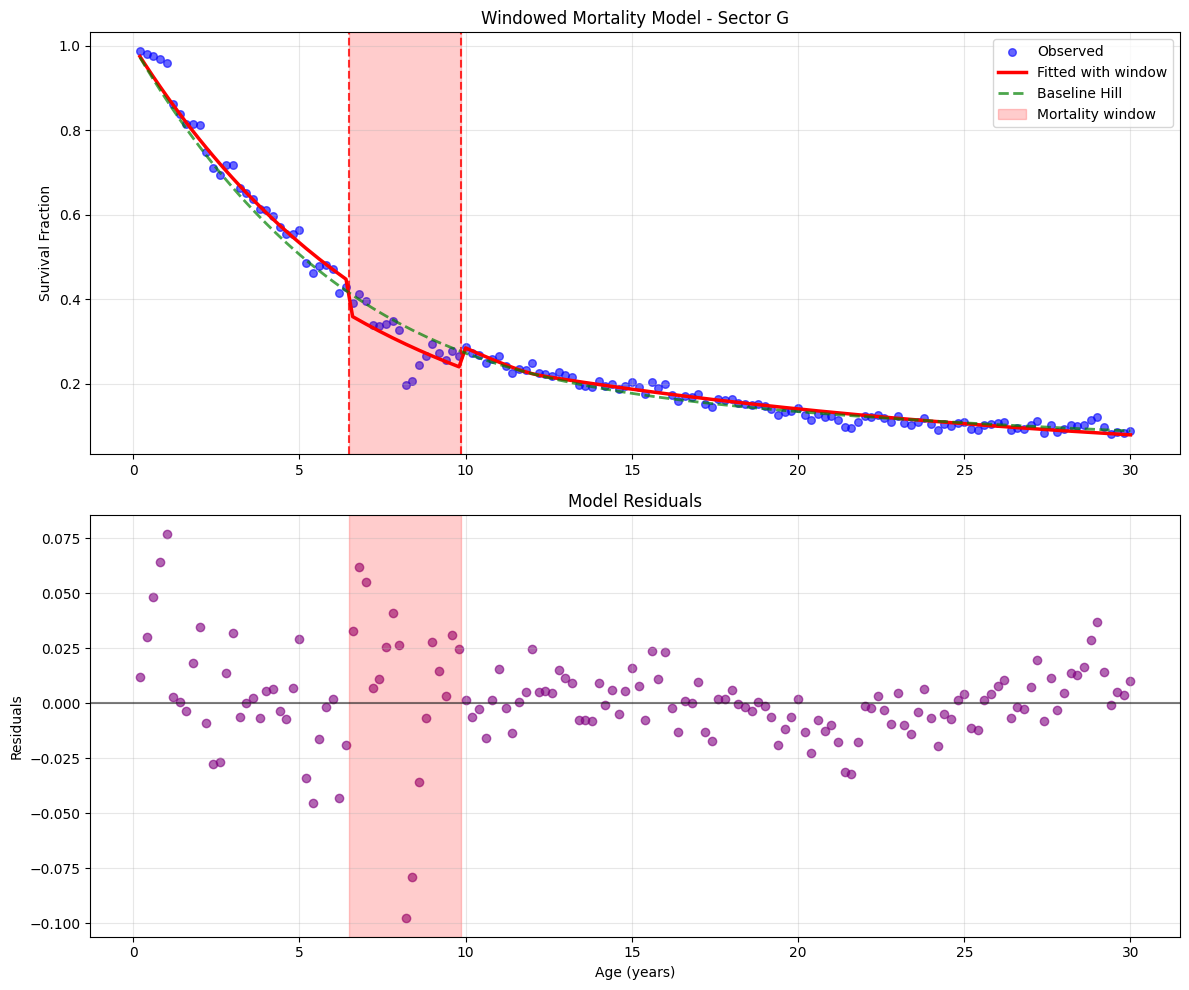


FINAL RESULTS FOR SECTOR G
Hill parameters:
  mu_ub = 0.125540
  mu_lb = 0.05738760
  K = 11.944
  m = 66.829

Mortality window parameters:
  Trigger age = 6.50 years
  Mortality reduction = 0.178 (17.8% reduction)
  Window width = 3.34 years
  Window end = 9.85 years

Model fit:
  Log-likelihood = -198006.28
  Baseline Hill LL = -198383.83
  Improvement = 377.55

Validation:
  Target dip: ages 5-10
  Fitted window: ages 6.5-9.8
  Overlap with target: 3.3 years
Data summary: 150 age points, range 0.2 to 30.0
Survival range: 0.093 to 0.993
Dip appears to be between indices 24 and 49
Corresponding to ages 5.0 to 10.0
Fitting windowed mortality model...
Using differential evolution for global optimization...
differential_evolution step 1: f(x)= 107150.34686147176
differential_evolution step 2: f(x)= 106896.20719754843
differential_evolution step 3: f(x)= 106896.20719754843
differential_evolution step 4: f(x)= 106896.20719754843
differential_evolution step 5: f(x)= 106896.20719754843
diff

C:\Users\chong\AppData\Local\Temp\ipykernel_2224\3107269172.py:162: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_local = minimize(


Local optimization result: [1.00441072e-01 5.65099367e-02 1.32211975e+01 6.74460491e+01
 7.10590075e+00 1.31059875e-01 3.67478344e+00]
Final log-likelihood: -106778.16


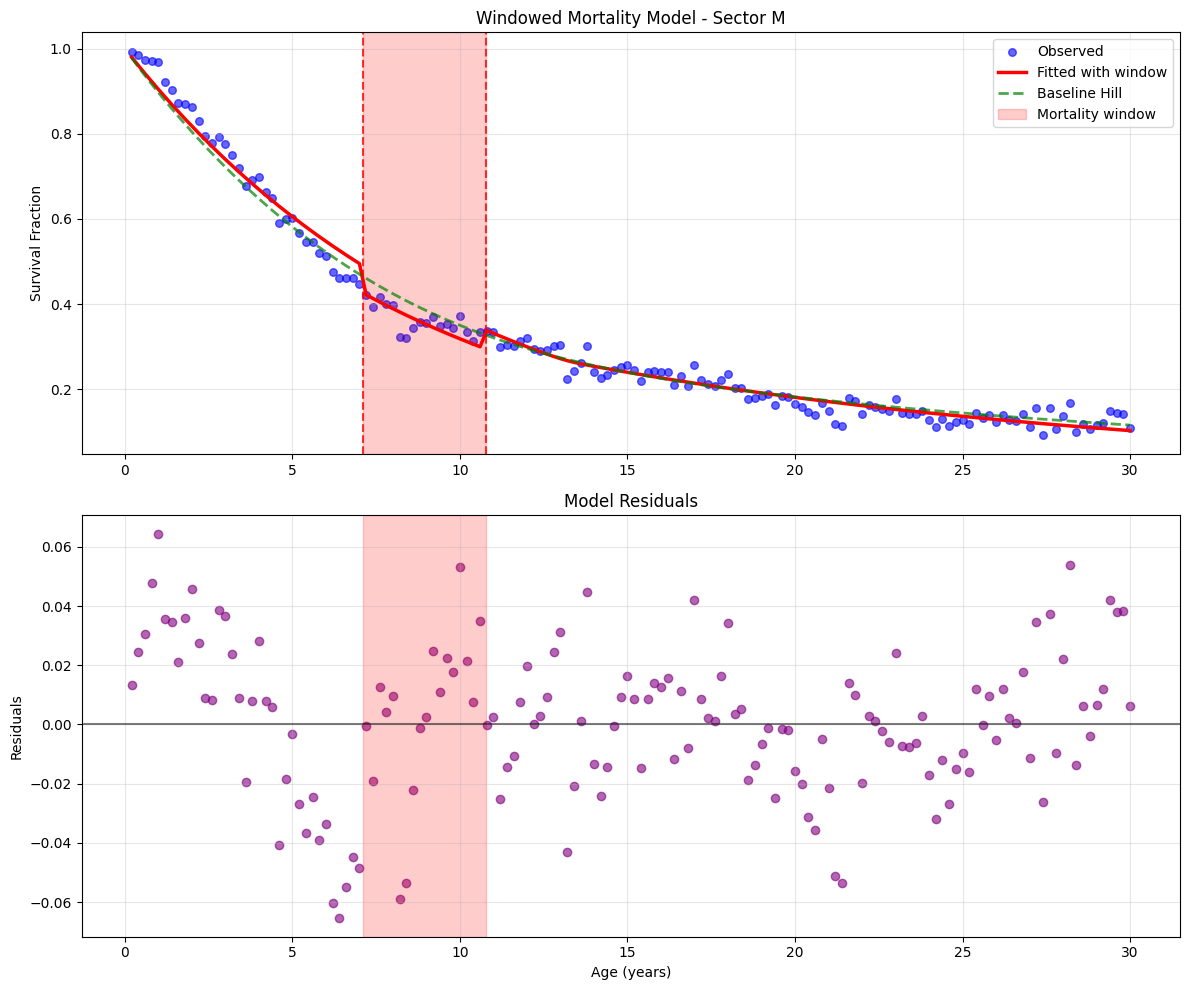


FINAL RESULTS FOR SECTOR M
Hill parameters:
  mu_ub = 0.100441
  mu_lb = 0.05650994
  K = 13.221
  m = 67.446

Mortality window parameters:
  Trigger age = 7.11 years
  Mortality reduction = 0.131 (13.1% reduction)
  Window width = 3.67 years
  Window end = 10.78 years

Model fit:
  Log-likelihood = -106778.16
  Baseline Hill LL = -106918.43
  Improvement = 140.27

Validation:
  Target dip: ages 5-10
  Fitted window: ages 7.1-10.8
  Overlap with target: 2.9 years
Data summary: 150 age points, range 0.2 to 30.0
Survival range: 0.094 to 0.990
Dip appears to be between indices 24 and 49
Corresponding to ages 5.0 to 10.0
Fitting windowed mortality model...
Using differential evolution for global optimization...
differential_evolution step 1: f(x)= 47859.431535468684
differential_evolution step 2: f(x)= 47859.431535468684
differential_evolution step 3: f(x)= 47859.431535468684
differential_evolution step 4: f(x)= 47859.431535468684
differential_evolution step 5: f(x)= 47859.431535468684
di

C:\Users\chong\AppData\Local\Temp\ipykernel_2224\3107269172.py:162: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_local = minimize(


Local optimization result: [ 0.07812053  0.07811246  7.37384555 57.54302355  4.626454    0.06670808
  3.67276135]
Final log-likelihood: -47759.99


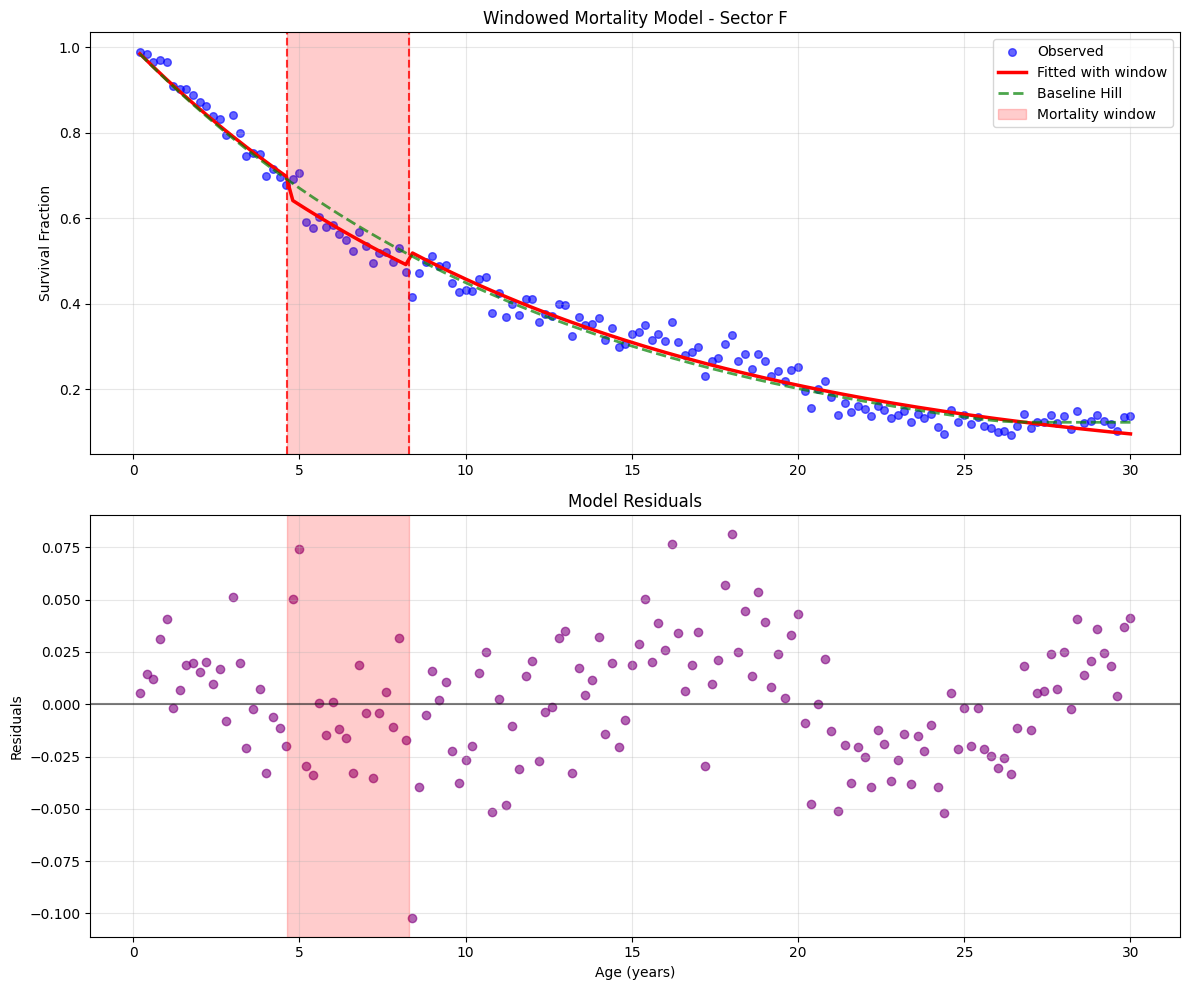


FINAL RESULTS FOR SECTOR F
Hill parameters:
  mu_ub = 0.078121
  mu_lb = 0.07811246
  K = 7.374
  m = 57.543

Mortality window parameters:
  Trigger age = 4.63 years
  Mortality reduction = 0.067 (6.7% reduction)
  Window width = 3.67 years
  Window end = 8.30 years

Model fit:
  Log-likelihood = -47759.99
  Baseline Hill LL = -47767.99
  Improvement = 8.01

Validation:
  Target dip: ages 5-10
  Fitted window: ages 4.6-8.3
  Overlap with target: 3.3 years
Data summary: 150 age points, range 0.2 to 30.0
Survival range: 0.073 to 0.993
Dip appears to be between indices 24 and 49
Corresponding to ages 5.0 to 10.0
Fitting windowed mortality model...
Using differential evolution for global optimization...
differential_evolution step 1: f(x)= 57296.47212225887
differential_evolution step 2: f(x)= 57071.23024198717
differential_evolution step 3: f(x)= 57039.0306308454
differential_evolution step 4: f(x)= 56967.631118044555
differential_evolution step 5: f(x)= 56967.631118044555
differential_e

C:\Users\chong\AppData\Local\Temp\ipykernel_2224\3107269172.py:162: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_local = minimize(


Local optimization result: [ 0.12310933  0.05938361 10.93858824 22.61544558  4.37048665  0.10224379
  3.19814377]
Final log-likelihood: -56916.09


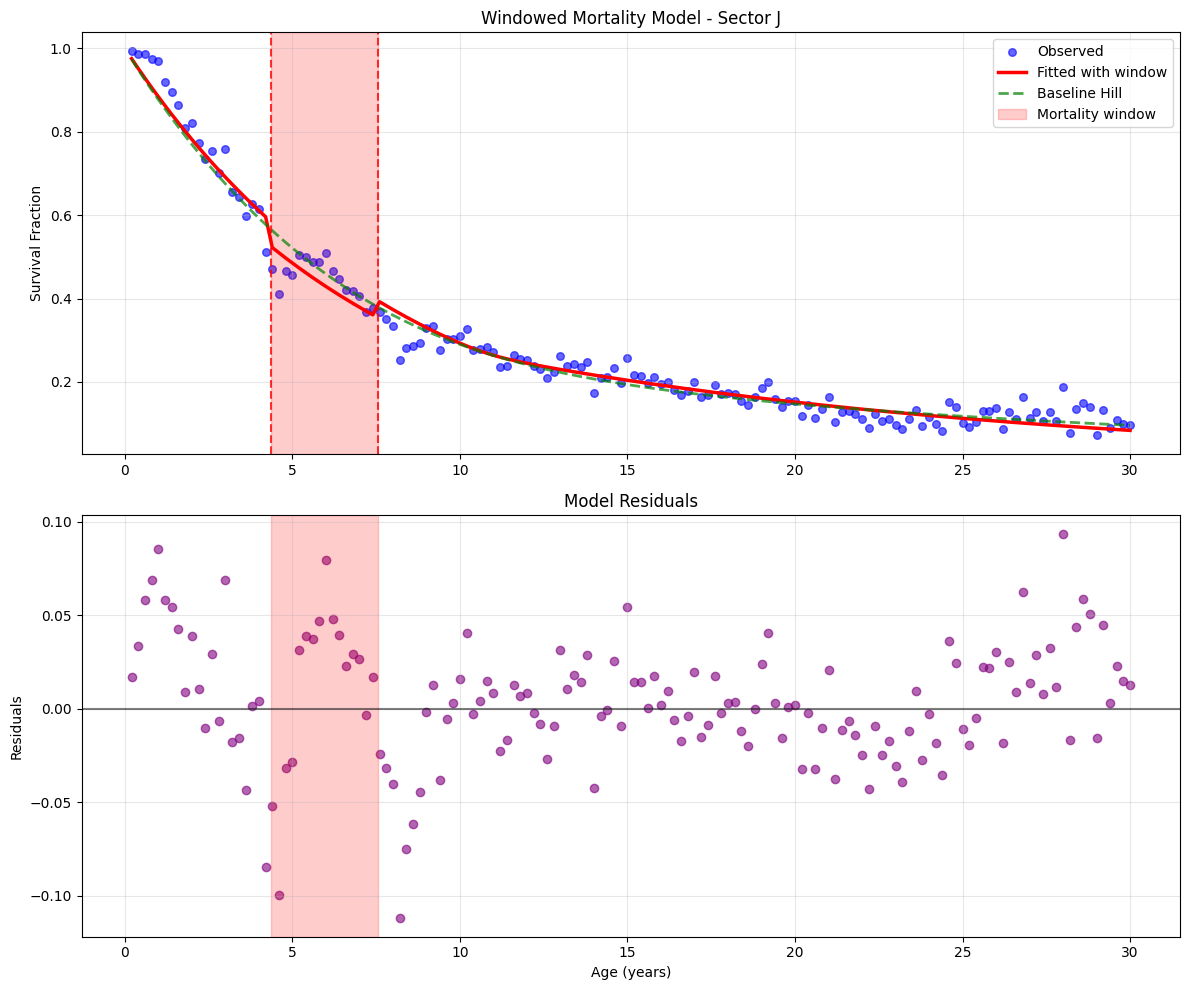


FINAL RESULTS FOR SECTOR J
Hill parameters:
  mu_ub = 0.123109
  mu_lb = 0.05938361
  K = 10.939
  m = 22.615

Mortality window parameters:
  Trigger age = 4.37 years
  Mortality reduction = 0.102 (10.2% reduction)
  Window width = 3.20 years
  Window end = 7.57 years

Model fit:
  Log-likelihood = -56916.09
  Baseline Hill LL = -56995.14
  Improvement = 79.05

Validation:
  Target dip: ages 5-10
  Fitted window: ages 4.4-7.6
  Overlap with target: 2.6 years
Data summary: 150 age points, range 0.2 to 30.0
Survival range: 0.192 to 0.993
Dip appears to be between indices 24 and 49
Corresponding to ages 5.0 to 10.0
Fitting windowed mortality model...
Using differential evolution for global optimization...
differential_evolution step 1: f(x)= 57050.933095838984
differential_evolution step 2: f(x)= 57050.933095838984
differential_evolution step 3: f(x)= 57050.933095838984
differential_evolution step 4: f(x)= 56536.437436770604
differential_evolution step 5: f(x)= 56248.15514683515
differen

C:\Users\chong\AppData\Local\Temp\ipykernel_2224\3107269172.py:162: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_local = minimize(


Local optimization result: [6.94533619e-02 2.09209823e-02 1.63988704e+01 9.42568894e+01
 8.45448609e+00 4.54408850e-02 1.74894730e+00]
Final log-likelihood: -56206.79


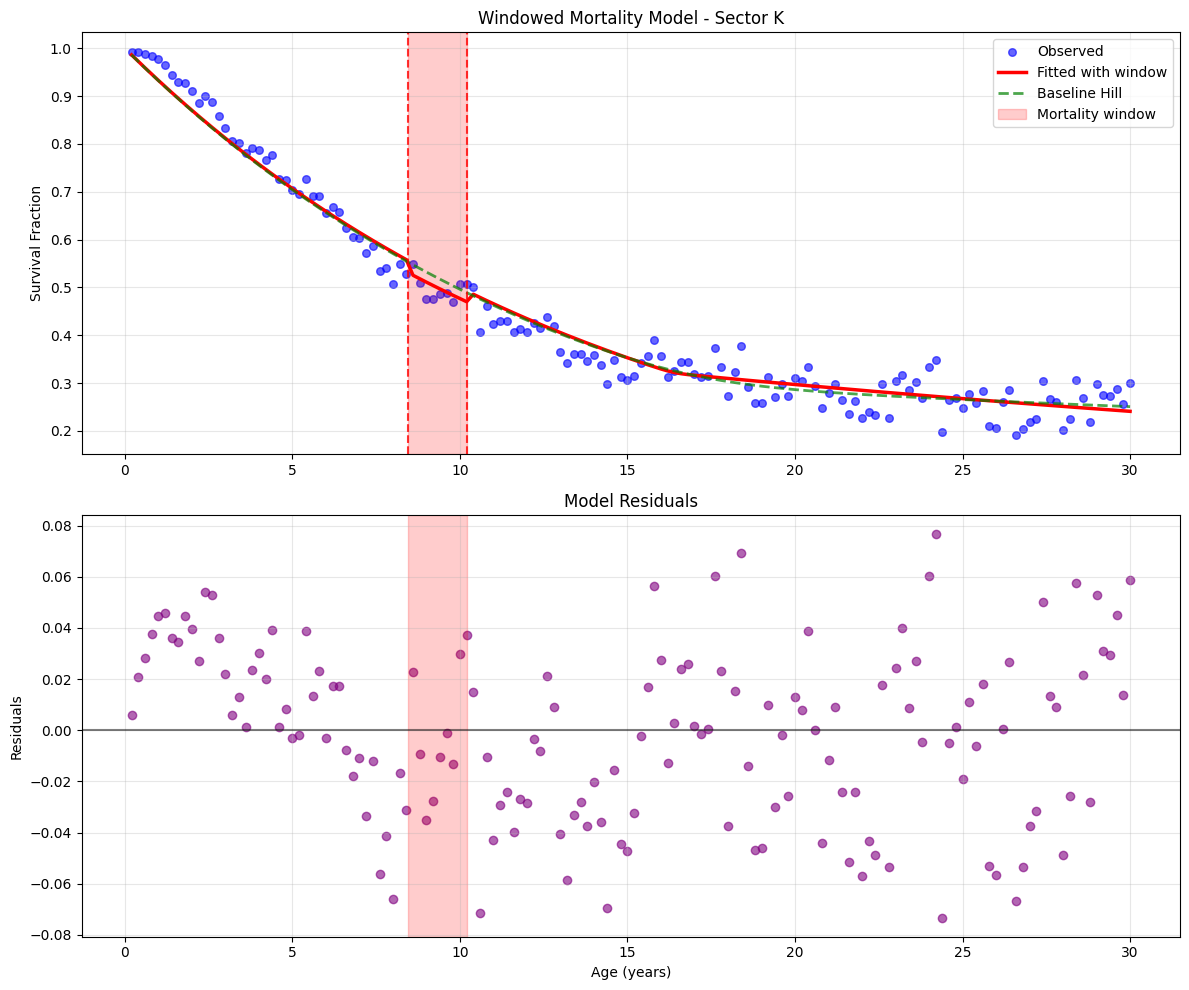


FINAL RESULTS FOR SECTOR K
Hill parameters:
  mu_ub = 0.069453
  mu_lb = 0.02092098
  K = 16.399
  m = 94.257

Mortality window parameters:
  Trigger age = 8.45 years
  Mortality reduction = 0.045 (4.5% reduction)
  Window width = 1.75 years
  Window end = 10.20 years

Model fit:
  Log-likelihood = -56206.79
  Baseline Hill LL = -56212.88
  Improvement = 6.09

Validation:
  Target dip: ages 5-10
  Fitted window: ages 8.5-10.2
  Overlap with target: 1.5 years
Data summary: 150 age points, range 0.2 to 30.0
Survival range: 0.136 to 0.997
Dip appears to be between indices 24 and 49
Corresponding to ages 5.0 to 10.0
Fitting windowed mortality model...
Using differential evolution for global optimization...
differential_evolution step 1: f(x)= 39686.947706171595
differential_evolution step 2: f(x)= 39678.94033516819
differential_evolution step 3: f(x)= 39678.94033516819
differential_evolution step 4: f(x)= 39640.207782202706
differential_evolution step 5: f(x)= 39607.790947758665
different

C:\Users\chong\AppData\Local\Temp\ipykernel_2224\3107269172.py:162: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_local = minimize(


Local optimization result: [9.72325749e-02 4.92888079e-02 9.19225354e+00 9.43962394e+01
 7.43777576e+00 7.61972236e-02 1.55934171e+00]
Final log-likelihood: -39529.22


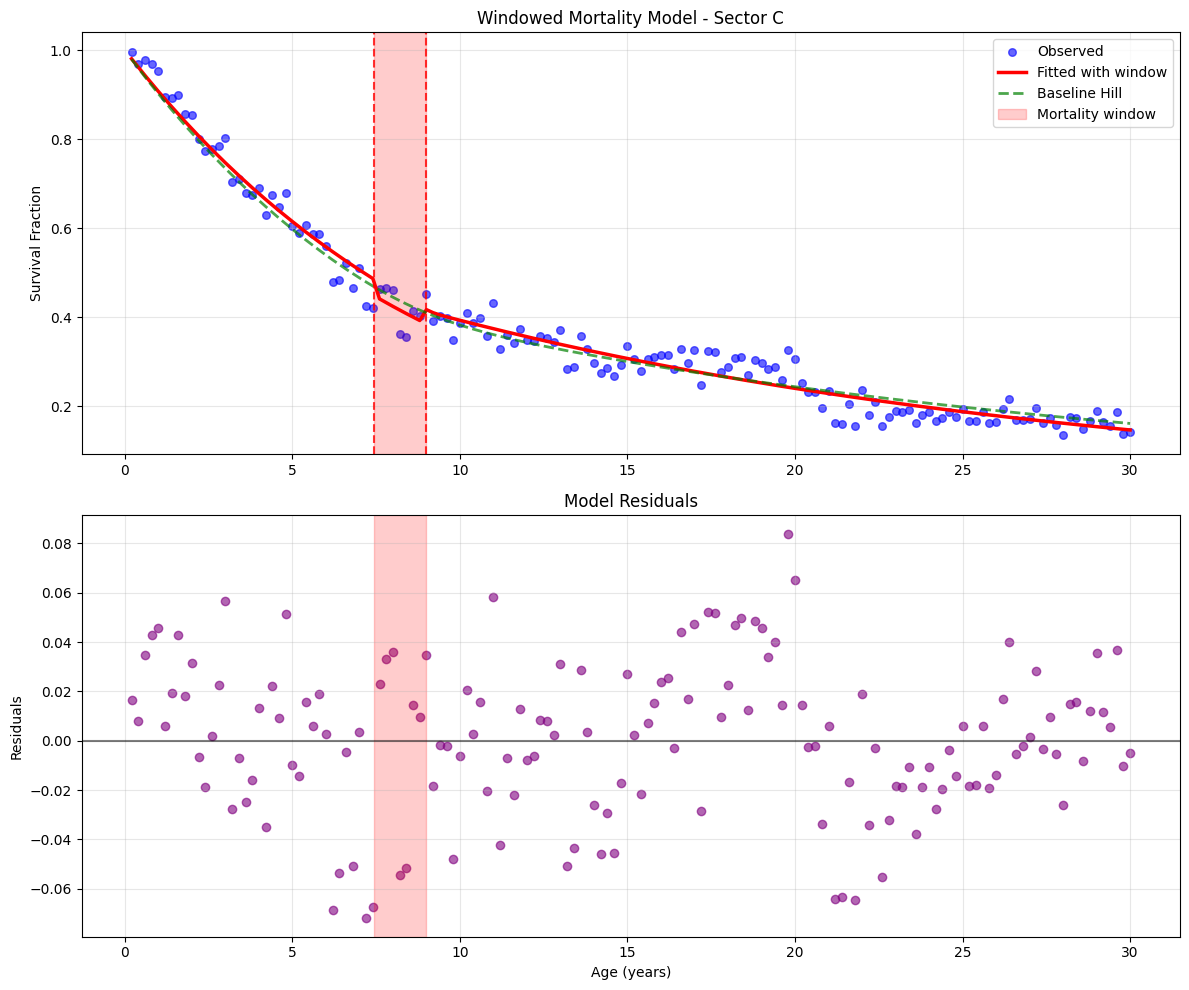


FINAL RESULTS FOR SECTOR C
Hill parameters:
  mu_ub = 0.097233
  mu_lb = 0.04928881
  K = 9.192
  m = 94.396

Mortality window parameters:
  Trigger age = 7.44 years
  Mortality reduction = 0.076 (7.6% reduction)
  Window width = 1.56 years
  Window end = 9.00 years

Model fit:
  Log-likelihood = -39529.22
  Baseline Hill LL = -39556.73
  Improvement = 27.51

Validation:
  Target dip: ages 5-10
  Fitted window: ages 7.4-9.0
  Overlap with target: 1.6 years
Data summary: 150 age points, range 0.2 to 30.0
Survival range: 0.085 to 0.997
Dip appears to be between indices 24 and 49
Corresponding to ages 5.0 to 10.0
Fitting windowed mortality model...
Using differential evolution for global optimization...
differential_evolution step 1: f(x)= 42494.53857818617
differential_evolution step 2: f(x)= 42494.53857818617
differential_evolution step 3: f(x)= 42494.53857818617
differential_evolution step 4: f(x)= 42105.37436949801
differential_evolution step 5: f(x)= 42105.37436949801
differential_e

C:\Users\chong\AppData\Local\Temp\ipykernel_2224\3107269172.py:162: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_local = minimize(


Local optimization result: [1.30055750e-01 5.67458071e-02 7.51622787e+00 8.00452095e+01
 5.58490907e+00 5.35952180e-01 2.38073638e+00]
Final log-likelihood: -41729.75


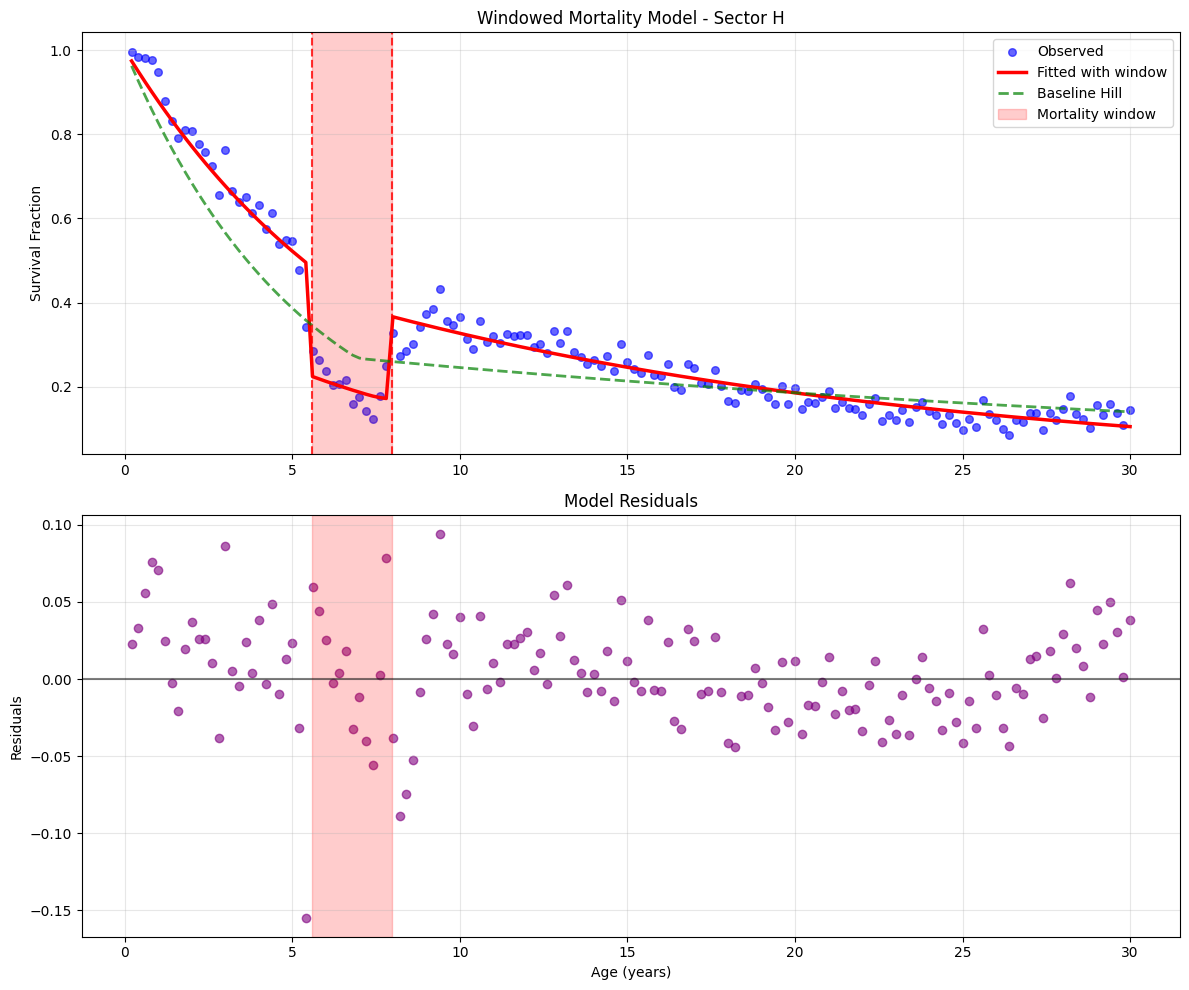


FINAL RESULTS FOR SECTOR H
Hill parameters:
  mu_ub = 0.130056
  mu_lb = 0.05674581
  K = 7.516
  m = 80.045

Mortality window parameters:
  Trigger age = 5.58 years
  Mortality reduction = 0.536 (53.6% reduction)
  Window width = 2.38 years
  Window end = 7.97 years

Model fit:
  Log-likelihood = -41729.75
  Baseline Hill LL = -42974.85
  Improvement = 1245.10

Validation:
  Target dip: ages 5-10
  Fitted window: ages 5.6-8.0
  Overlap with target: 2.4 years
Data summary: 150 age points, range 0.2 to 30.0
Survival range: 0.101 to 0.992
Dip appears to be between indices 24 and 49
Corresponding to ages 5.0 to 10.0
Fitting windowed mortality model...
Using differential evolution for global optimization...
differential_evolution step 1: f(x)= 35876.4380071855
differential_evolution step 2: f(x)= 35832.41926115647
differential_evolution step 3: f(x)= 35832.41926115647
differential_evolution step 4: f(x)= 35832.41926115647
differential_evolution step 5: f(x)= 35828.165720983554
differentia

C:\Users\chong\AppData\Local\Temp\ipykernel_2224\3107269172.py:162: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_local = minimize(


Local optimization result: [1.31201920e-01 1.33746166e-02 1.33517965e+01 3.91457414e+01
 7.14058230e+00 2.00130624e-01 1.57253625e+00]
Final log-likelihood: -35729.83


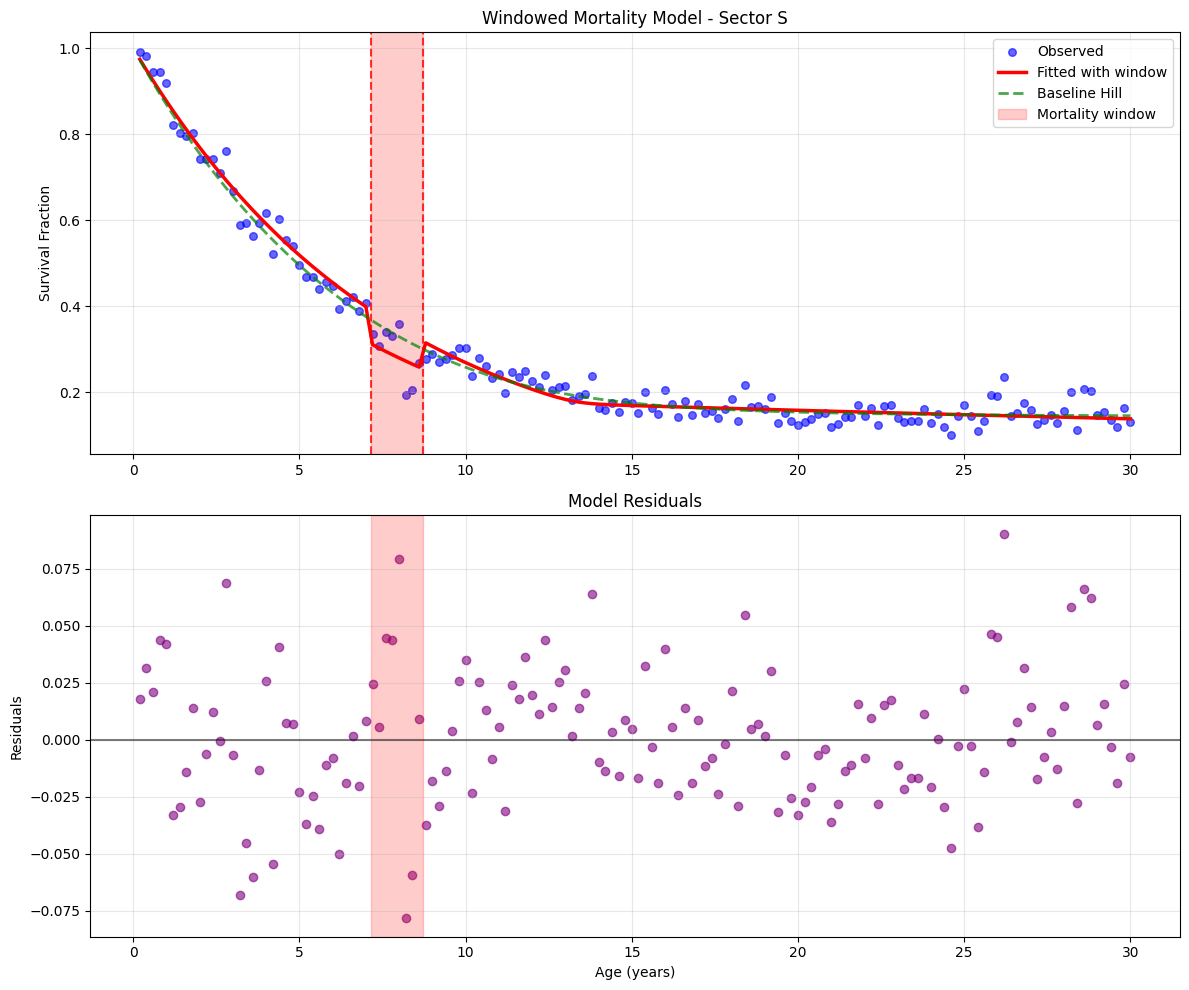


FINAL RESULTS FOR SECTOR S
Hill parameters:
  mu_ub = 0.131202
  mu_lb = 0.01337462
  K = 13.352
  m = 39.146

Mortality window parameters:
  Trigger age = 7.14 years
  Mortality reduction = 0.200 (20.0% reduction)
  Window width = 1.57 years
  Window end = 8.71 years

Model fit:
  Log-likelihood = -35729.83
  Baseline Hill LL = -35752.29
  Improvement = 22.46

Validation:
  Target dip: ages 5-10
  Fitted window: ages 7.1-8.7
  Overlap with target: 1.6 years
Data summary: 150 age points, range 0.2 to 30.0
Survival range: 0.090 to 0.979
Dip appears to be between indices 24 and 49
Corresponding to ages 5.0 to 10.0
Fitting windowed mortality model...
Using differential evolution for global optimization...
differential_evolution step 1: f(x)= 37144.87841500703
differential_evolution step 2: f(x)= 37121.63709454573
differential_evolution step 3: f(x)= 37121.63709454573
differential_evolution step 4: f(x)= 37025.79042575958
differential_evolution step 5: f(x)= 37025.79042575958
differential

C:\Users\chong\AppData\Local\Temp\ipykernel_2224\3107269172.py:162: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_local = minimize(


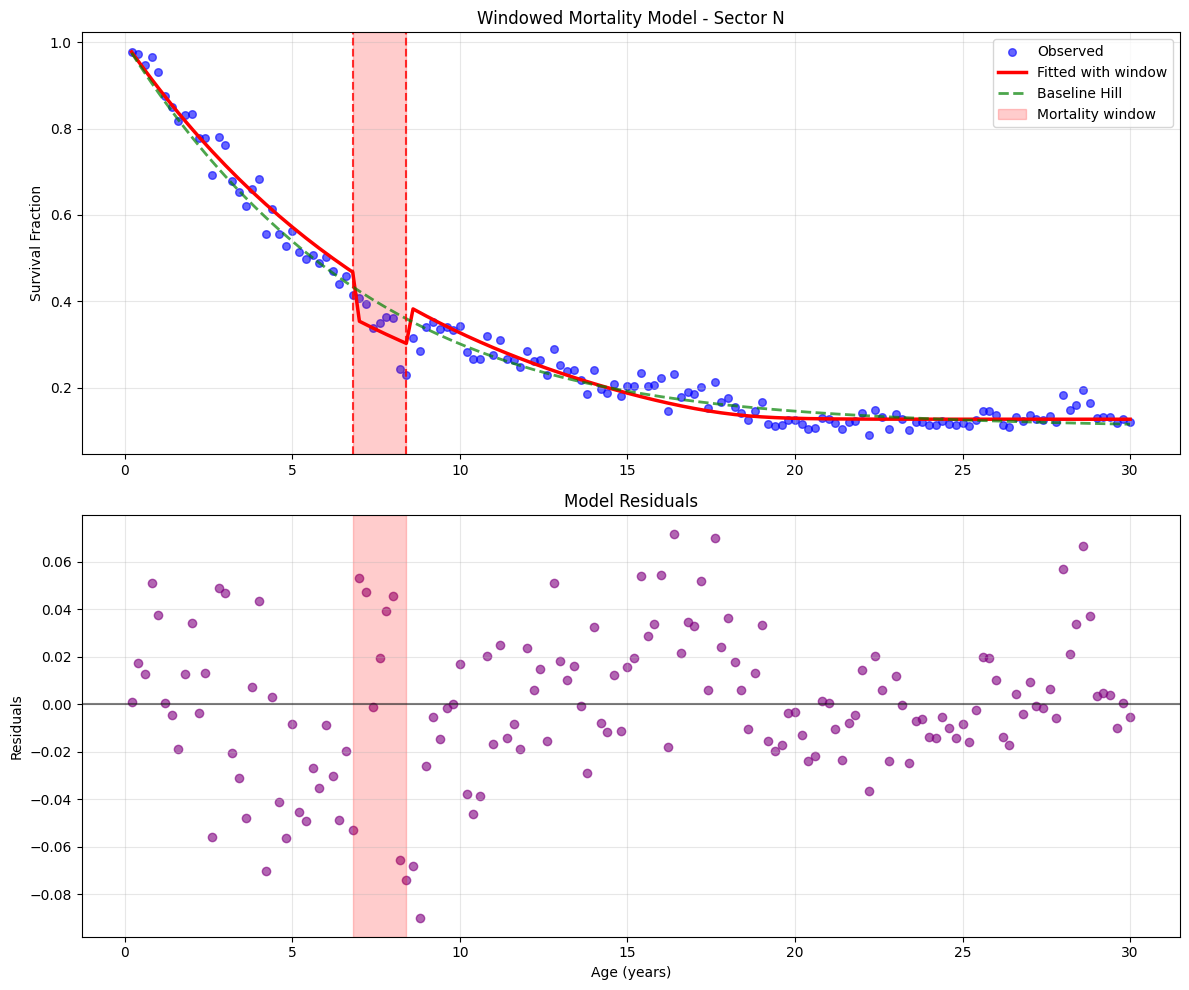


FINAL RESULTS FOR SECTOR N
Hill parameters:
  mu_ub = 0.111832
  mu_lb = 0.00000000
  K = 18.416
  m = 21.702

Mortality window parameters:
  Trigger age = 6.82 years
  Mortality reduction = 0.227 (22.7% reduction)
  Window width = 1.58 years
  Window end = 8.40 years

Model fit:
  Log-likelihood = -36974.02
  Baseline Hill LL = -37012.32
  Improvement = 38.31

Validation:
  Target dip: ages 5-10
  Fitted window: ages 6.8-8.4
  Overlap with target: 1.6 years
Data summary: 150 age points, range 0.2 to 30.0
Survival range: 0.042 to 0.984
Dip appears to be between indices 24 and 49
Corresponding to ages 5.0 to 10.0
Fitting windowed mortality model...
Using differential evolution for global optimization...
differential_evolution step 1: f(x)= 34380.67485423342
differential_evolution step 2: f(x)= 34349.764025797456
differential_evolution step 3: f(x)= 34320.052753792435
differential_evolution step 4: f(x)= 34320.052753792435
differential_evolution step 5: f(x)= 34302.068332444935
differen

C:\Users\chong\AppData\Local\Temp\ipykernel_2224\3107269172.py:162: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_local = minimize(


Local optimization result: [1.20014954e-01 1.89233934e-02 1.99893331e+01 7.52939399e+01
 6.70317080e+00 1.35539588e-01 1.91042865e+00]
Final log-likelihood: -34232.88


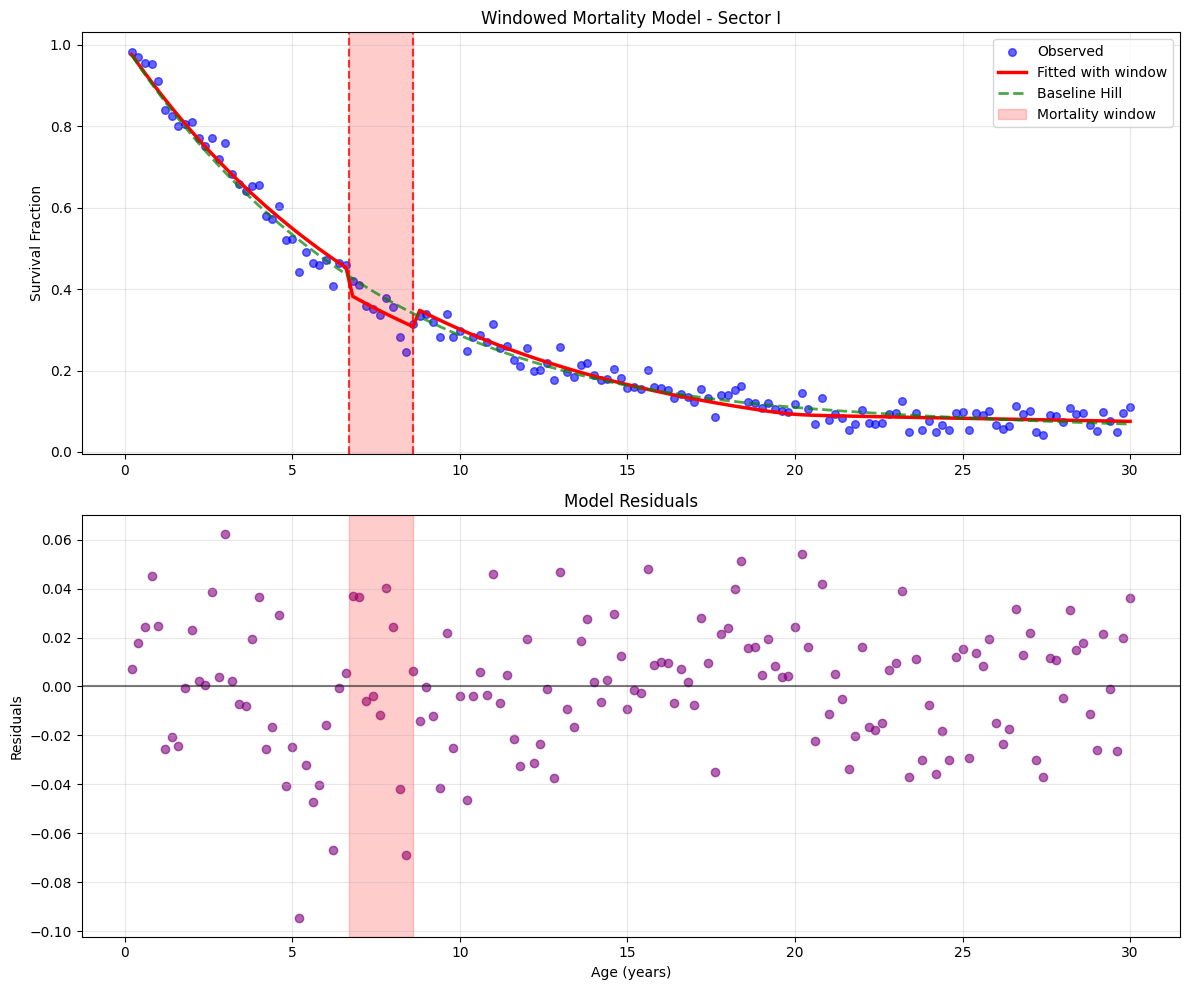


FINAL RESULTS FOR SECTOR I
Hill parameters:
  mu_ub = 0.120015
  mu_lb = 0.01892339
  K = 19.989
  m = 75.294

Mortality window parameters:
  Trigger age = 6.70 years
  Mortality reduction = 0.136 (13.6% reduction)
  Window width = 1.91 years
  Window end = 8.61 years

Model fit:
  Log-likelihood = -34232.88
  Baseline Hill LL = -34250.50
  Improvement = 17.62

Validation:
  Target dip: ages 5-10
  Fitted window: ages 6.7-8.6
  Overlap with target: 1.9 years
Data summary: 150 age points, range 0.2 to 30.0
Survival range: 0.040 to 0.996
Dip appears to be between indices 24 and 49
Corresponding to ages 5.0 to 10.0
Fitting windowed mortality model...
Using differential evolution for global optimization...
differential_evolution step 1: f(x)= 25320.01554371491
differential_evolution step 2: f(x)= 25320.01554371491
differential_evolution step 3: f(x)= 25252.17628531139
differential_evolution step 4: f(x)= 25187.130569405836
differential_evolution step 5: f(x)= 25187.130569405836
differenti

C:\Users\chong\AppData\Local\Temp\ipykernel_2224\3107269172.py:162: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_local = minimize(


Local optimization result: [1.14367107e-01 7.12796007e-02 1.03667519e+01 8.04902773e+01
 7.38149199e+00 1.30131621e-01 2.90612981e+00]
Final log-likelihood: -25132.13


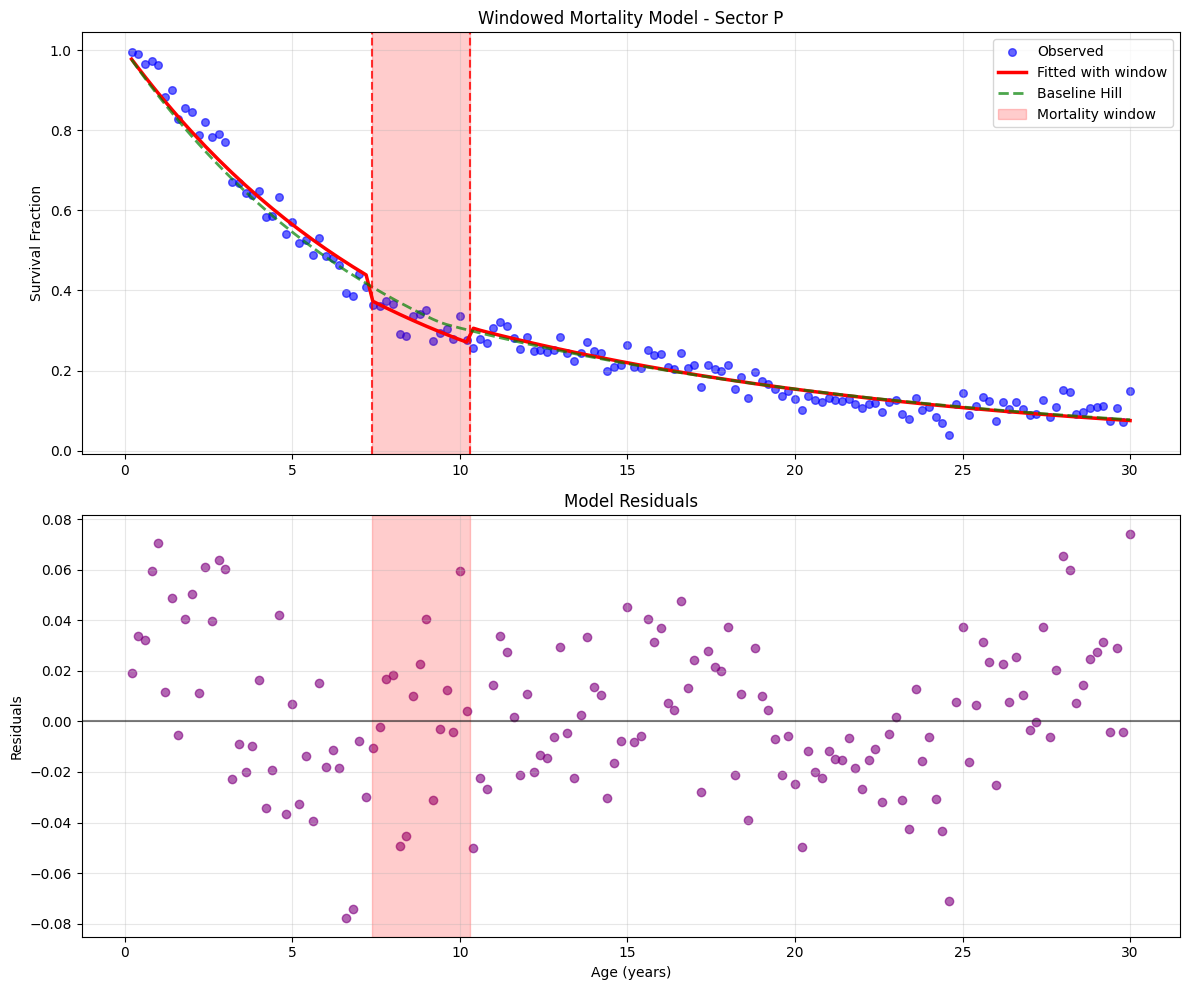


FINAL RESULTS FOR SECTOR P
Hill parameters:
  mu_ub = 0.114367
  mu_lb = 0.07127960
  K = 10.367
  m = 80.490

Mortality window parameters:
  Trigger age = 7.38 years
  Mortality reduction = 0.130 (13.0% reduction)
  Window width = 2.91 years
  Window end = 10.29 years

Model fit:
  Log-likelihood = -25132.13
  Baseline Hill LL = -25155.90
  Improvement = 23.78

Validation:
  Target dip: ages 5-10
  Fitted window: ages 7.4-10.3
  Overlap with target: 2.6 years
Data summary: 150 age points, range 0.2 to 30.0
Survival range: 0.076 to 0.984
Dip appears to be between indices 24 and 49
Corresponding to ages 5.0 to 10.0
Fitting windowed mortality model...
Using differential evolution for global optimization...
differential_evolution step 1: f(x)= 11987.83222267258
differential_evolution step 2: f(x)= 11987.83222267258
differential_evolution step 3: f(x)= 11934.029181659465
differential_evolution step 4: f(x)= 11934.029181659465
differential_evolution step 5: f(x)= 11928.271896864066
differe

C:\Users\chong\AppData\Local\Temp\ipykernel_2224\3107269172.py:162: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_local = minimize(


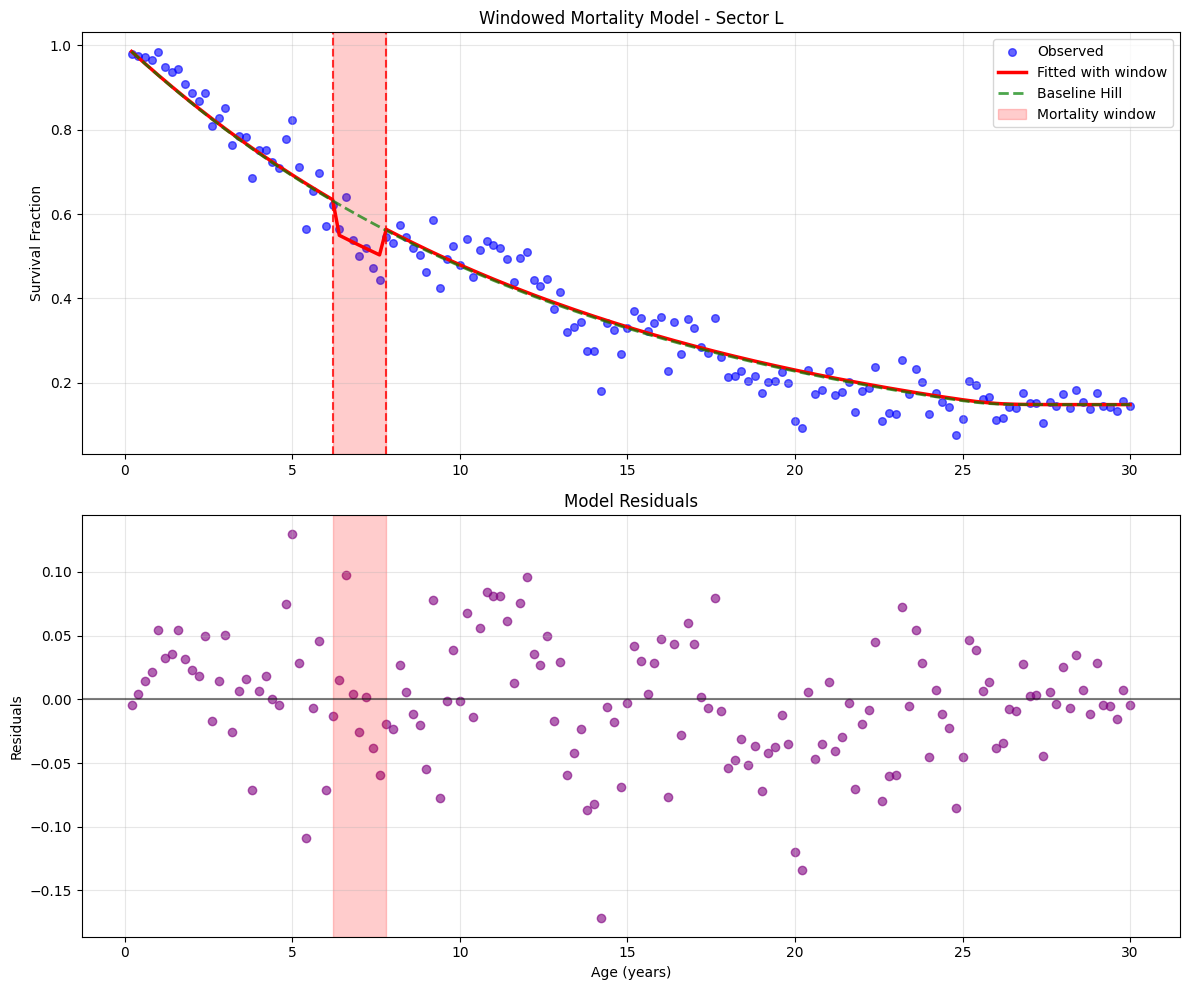


FINAL RESULTS FOR SECTOR L
Hill parameters:
  mu_ub = 0.073500
  mu_lb = 0.00000000
  K = 25.992
  m = 68.577

Mortality window parameters:
  Trigger age = 6.21 years
  Mortality reduction = 0.121 (12.1% reduction)
  Window width = 1.57 years
  Window end = 7.78 years

Model fit:
  Log-likelihood = -11910.92
  Baseline Hill LL = -11919.32
  Improvement = 8.40

Validation:
  Target dip: ages 5-10
  Fitted window: ages 6.2-7.8
  Overlap with target: 1.6 years
Data summary: 150 age points, range 0.2 to 30.0
Survival range: 0.089 to 1.000
Dip appears to be between indices 24 and 49
Corresponding to ages 5.0 to 10.0
Fitting windowed mortality model...
Using differential evolution for global optimization...
differential_evolution step 1: f(x)= 13007.595206406917
differential_evolution step 2: f(x)= 12989.817468698307
differential_evolution step 3: f(x)= 12957.7061186331
differential_evolution step 4: f(x)= 12957.7061186331
differential_evolution step 5: f(x)= 12957.7061186331
differential_e

C:\Users\chong\AppData\Local\Temp\ipykernel_2224\3107269172.py:162: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_local = minimize(


Local optimization result: [ 0.07718117  0.04997046  6.9213838  35.64078964  7.59993612  0.08874579
  1.52984382]
Final log-likelihood: -12882.12


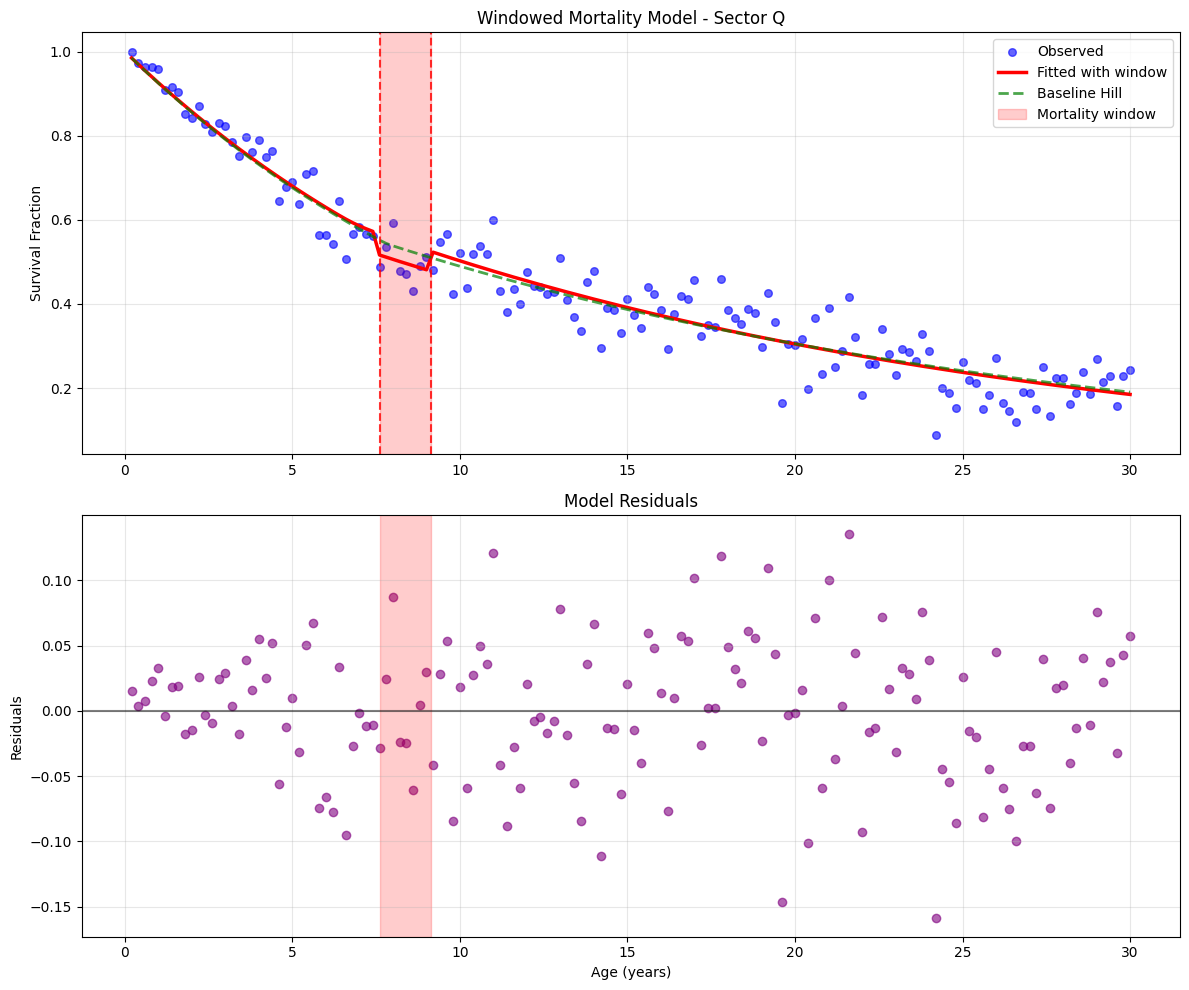


FINAL RESULTS FOR SECTOR Q
Hill parameters:
  mu_ub = 0.077181
  mu_lb = 0.04997046
  K = 6.921
  m = 35.641

Mortality window parameters:
  Trigger age = 7.60 years
  Mortality reduction = 0.089 (8.9% reduction)
  Window width = 1.53 years
  Window end = 9.13 years

Model fit:
  Log-likelihood = -12882.12
  Baseline Hill LL = -12888.58
  Improvement = 6.46

Validation:
  Target dip: ages 5-10
  Fitted window: ages 7.6-9.1
  Overlap with target: 1.5 years
Data summary: 150 age points, range 0.2 to 30.0
Survival range: 0.014 to 0.990
Dip appears to be between indices 24 and 49
Corresponding to ages 5.0 to 10.0
Fitting windowed mortality model...
Using differential evolution for global optimization...
differential_evolution step 1: f(x)= 7561.151854175612
differential_evolution step 2: f(x)= 7536.657648417306
differential_evolution step 3: f(x)= 7535.070976777542
differential_evolution step 4: f(x)= 7523.122544846885
differential_evolution step 5: f(x)= 7523.122544846885
differential_ev

C:\Users\chong\AppData\Local\Temp\ipykernel_2224\3107269172.py:162: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_local = minimize(


Local optimization result: [ 0.12483261  0.08699105 10.17715507 82.52030992  7.09112037  0.14314054
  2.54378738]
Final log-likelihood: -7512.68


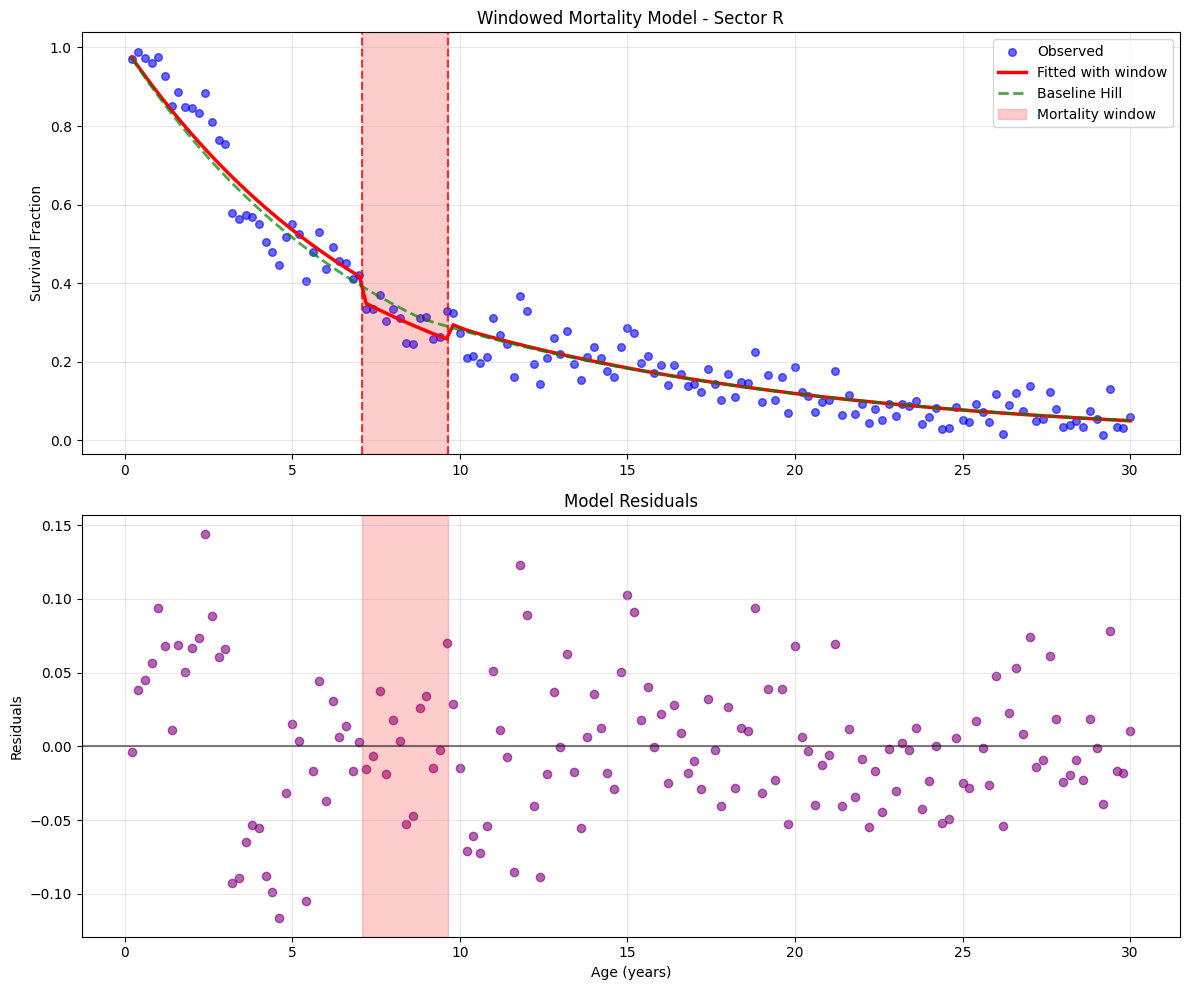


FINAL RESULTS FOR SECTOR R
Hill parameters:
  mu_ub = 0.124833
  mu_lb = 0.08699105
  K = 10.177
  m = 82.520

Mortality window parameters:
  Trigger age = 7.09 years
  Mortality reduction = 0.143 (14.3% reduction)
  Window width = 2.54 years
  Window end = 9.63 years

Model fit:
  Log-likelihood = -7512.68
  Baseline Hill LL = -7519.65
  Improvement = 6.96

Validation:
  Target dip: ages 5-10
  Fitted window: ages 7.1-9.6
  Overlap with target: 2.5 years


In [ ]:
from scipy.optimize import differential_evolution

# Step-wise survival reduction during window
def survival_with_step_window(a, mu_ub, mu_lb, K, m, trigger_age, mortality_reduction, delta_width):
    """
    Alternative: Apply a constant survival reduction factor during the window
    """
    if a <= 0:
        return 1.0
    
    try:
        # Base Hill survival
        base_survival = hill_survival_function(a, mu_ub, mu_lb, K, m)
        
        # Apply mortality reduction only during the window
        if trigger_age <= a <= trigger_age + delta_width:
            # Reduce survival by a constant factor during the window
            windowed_survival = base_survival * (1.0 - mortality_reduction)
        else:
            # Outside window, use base survival
            windowed_survival = base_survival
        
        return max(1e-12, min(1.0, windowed_survival))
        
    except Exception as e:
        return max(1e-12, np.exp(-a * mu_ub))

def model_survival_step_window(ages, mu_ub, mu_lb, K, m, trigger_age, mortality_reduction, delta_width):
    return np.array([
        survival_with_step_window(a, mu_ub, mu_lb, K, m, trigger_age, mortality_reduction, delta_width) 
        for a in ages
    ])

def neg_log_likelihood_step_window(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m, trigger_age, mortality_reduction, delta_width = params
    
    if (mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0 or 
        trigger_age < 0 or trigger_age >= max(ages) or
        mortality_reduction <= 0 or mortality_reduction >= 1 or delta_width <= 0):
        return 1e6
    
    try:
        S_vals = model_survival_step_window(ages, mu_ub, mu_lb, K, m, 
                                           trigger_age, mortality_reduction, delta_width)
        S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)
        
        deaths = totals - survivors
        logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
        return -logL
        
    except Exception:
        return 1e6

def fit_windowed_model_robust(ages, survivors, totals, df_params, sector):
    """
    Robust fitting using multiple strategies
    """
    print("Fitting windowed mortality model...")
    
    # Strategy 1: Multiple random starts with differential evolution
    bounds_de = [
        (0.01, 0.3),      # mu_ub
        (1e-10, 0.3),     # mu_lb
        (0.1, 30),        # K
        (0.5, 100),       # m
        (3, 10),          # trigger_age (focused on the visible dip)
        (0.01, 0.9),      # mortality_reduction (step window version)
        (0.5, 4)          # delta_width
    ]
    
    print("Using differential evolution for global optimization...")
    result_de = differential_evolution(
        neg_log_likelihood_step_window,
        bounds_de,
        args=(ages, survivors, totals),
        maxiter=200,
        seed=42,
        disp=True
    )
    
    print(f"Differential evolution result: {result_de.x}")
    print(f"Log-likelihood: {-result_de.fun:.2f}")
    
    # Strategy 2: Local refinement with L-BFGS-B
    print("\nRefining with L-BFGS-B...")
    result_local = minimize(
        neg_log_likelihood_step_window,
        result_de.x,
        args=(ages, survivors, totals),
        method='L-BFGS-B',
        bounds=bounds_de,
        options={'maxiter': 300, 'disp': True}
    )
    
    print(f"Local optimization result: {result_local.x}")
    print(f"Final log-likelihood: {-result_local.fun:.2f}")
    
    return result_local

# Test with your data
for sector in sector_list:
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)

    print(f"Data summary: {len(ages)} age points, range {min(ages):.1f} to {max(ages):.1f}")
    print(f"Survival range: {min(survival_fractions):.3f} to {max(survival_fractions):.3f}")

    # Fit the model
    result = fit_windowed_model_robust(ages, survivors, totals, df_params, sector)

    # Plot results with detailed annotations
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Top plot: Survival curves
    ax1.scatter(ages, survival_fractions, alpha=0.6, s=30, label='Observed', color='blue')
    fitted_survival = model_survival_step_window(ages, *result.x)
    ax1.plot(ages, fitted_survival, 'r-', linewidth=2.5, label='Fitted with window')

    # Also plot baseline Hill model for comparison
    baseline_survival = model_survival_curve_hill(ages, *df_params.loc[sector])
    ax1.plot(ages, baseline_survival, 'g--', linewidth=2, label='Baseline Hill', alpha=0.7)

    # Mark the mortality window
    trigger_age_fit = result.x[4]
    delta_width_fit = result.x[6]
    window_end = trigger_age_fit + delta_width_fit

    # Shade the mortality window
    ax1.axvspan(trigger_age_fit, window_end, alpha=0.2, color='red', label=f'Mortality window')
    ax1.axvline(x=trigger_age_fit, color='red', linestyle='--', alpha=0.8)
    ax1.axvline(x=window_end, color='red', linestyle='--', alpha=0.8)

    ax1.set_ylabel('Survival Fraction')
    ax1.set_title(f'Windowed Mortality Model - Sector {sector}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Bottom plot: Residuals
    residuals = survival_fractions - fitted_survival
    ax2.scatter(ages, residuals, alpha=0.6, color='purple')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.axvspan(trigger_age_fit, window_end, alpha=0.2, color='red')
    ax2.set_xlabel('Age (years)')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Model Residuals')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print(f"\n{'='*60}")
    print(f"FINAL RESULTS FOR SECTOR {sector}")
    print(f"{'='*60}")
    print(f"Hill parameters:")
    print(f"  mu_ub = {result.x[0]:.6f}")
    print(f"  mu_lb = {result.x[1]:.8f}") 
    print(f"  K = {result.x[2]:.3f}")
    print(f"  m = {result.x[3]:.3f}")
    print(f"\nMortality window parameters:")
    print(f"  Trigger age = {result.x[4]:.2f} years")
    print(f"  Mortality reduction = {result.x[5]:.3f} ({result.x[5]*100:.1f}% reduction)")
    print(f"  Window width = {result.x[6]:.2f} years")
    print(f"  Window end = {result.x[4] + result.x[6]:.2f} years")
    print(f"\nModel fit:")
    print(f"  Log-likelihood = {-result.fun:.2f}")

    # Calculate baseline model for comparison
    baseline_ll = -neg_log_likelihood_hill(df_params.loc[sector], ages, survivors, totals)
    print(f"  Baseline Hill LL = {baseline_ll:.2f}")
    print(f"  Improvement = {-result.fun - baseline_ll:.2f}")

    # Check if the window actually captures the dip
    print(f"\nValidation:")
    print(f"  Target dip: ages 5-10")
    print(f"  Fitted window: ages {result.x[4]:.1f}-{result.x[4]+result.x[6]:.1f}")
    overlap = max(0, min(10, result.x[4]+result.x[6]) - max(5, result.x[4]))
    print(f"  Overlap with target: {overlap:.1f} years")